<a href="https://colab.research.google.com/github/rygo1232/ryan1/blob/main/DP_MODEL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **install packages**

In [1]:
pip install tensorflow tensorflow-probability numpy matplotlib scikit-learn


In [2]:
!pip install bayesian-optimization


In [3]:
pip install --upgrade tensorflow shap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.9/644.9 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 58.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 58.0 MB/s eta 0:00:00
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.4.1
    Uninstalling ml-dtypes-0.4.1:
      Successfully uninstalled ml-dtypes-0.4.1
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.18.0
    Uninstalling tensorboard-2.18.0:
      Successfully uninstalled tensorboard-2.18.0
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.18.0
    Uninstalling tensorflow-2.18.0:
      Successfully uninstalled tensorflow-2.18.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-decision-forests 1.11.0 requires tensorflow==2.18.0, but you have tens

In [4]:
!pip install keras_tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 2.9 MB/s eta 0:00:00


# **Call Packages**

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
import tensorflow_probability as tfp
from sklearn.model_selection import train_test_split,KFold
from sklearn.preprocessing import StandardScaler, LabelEncoder, RobustScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score,confusion_matrix,roc_curve, auc, precision_recall_curve, precision_recall_fscore_support
from sklearn.utils import shuffle
from tensorflow.keras import layers, Model, optimizers
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, LSTM, Input, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras import regularizers
from tensorflow.keras.regularizers import l2
from google.colab import drive
from sklearn.feature_selection import SelectKBest, f_regression
from scipy import stats
from sklearn.model_selection import TimeSeriesSplit, KFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.utils import shuffle
tfd = tfp.distributions



# **Data load**

In [6]:
url = 'https://github.com/rygo1232/ryan1/raw/refs/heads/main/OPR_Data_dp.xlsx'
opr_data = pd.read_excel(url)
opr_data.head()

,Date,loss,Internal_fraud,External_fraud,Employ_PWS,Clients_PBP,Disaster,ICT_Failure,Execution_DP
0,1980,36018.753329,1750.451152,724.457873,1654.193170,21567.986642,211.948435,5250.449005,4859.267052
1,1981,29372.554728,1892.549168,1520.499982,646.700805,11387.686902,173.970695,4141.188918,9609.958258
2,1982,38563.417720,2258.135870,2004.194960,1721.763552,15672.845439,104.770430,5244.595006,11557.112464
3,1983,34344.402654,2237.661436,2037.584475,2013.382715,11764.072979,48.245058,6086.596058,10156.859932
4,1984,31823.887478,535.631442,1639.947623,1448.060942,11958.526408,155.857865,5097.720141,10988.143057


# **Explaratory ANalysis**


**density and histogram**

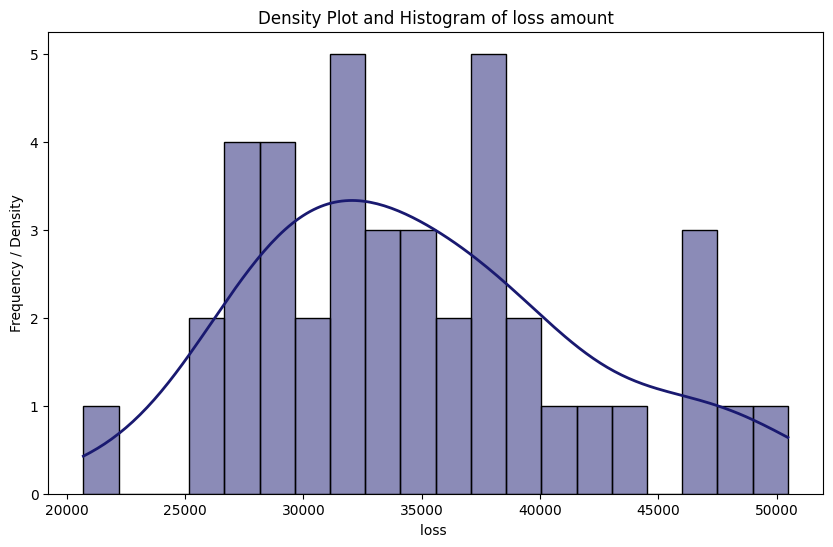

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot density and histogram for 'Amount_claimed'
plt.figure(figsize=(10, 6))
sns.histplot(
    opr_data['loss'],  # Use the specified column
    bins=20,
    kde=True,
    color='MidnightBlue',
    # The 'linewidth' parameter should be in 'line_kws' for kde plot
    line_kws={'linewidth': 2},
    edgecolor='black'  # Adds black edges to bars for better visibility
)

plt.title('Density Plot and Histogram of loss amount')
plt.xlabel('loss ')
plt.ylabel('Frequency / Density')
plt.show()

**BOXPLOT**

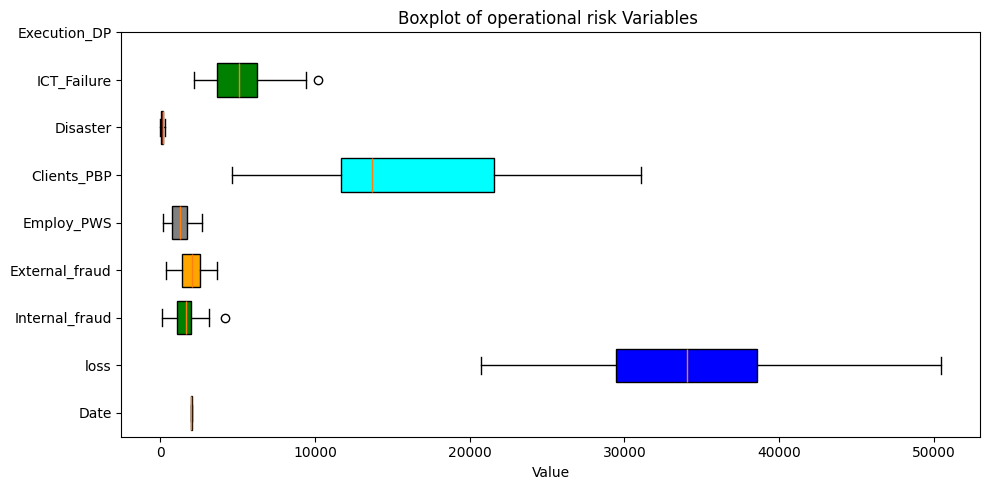

In [8]:
import matplotlib.pyplot as plt

# Remove 'loss_category' from the columns if it exists
columns_to_plot = [col for col in opr_data.columns if col != 'loss_category']

# Set a larger figure size for better visibility
plt.figure(figsize=(10, 5))

# Get data for each variable
data = [opr_data[col].dropna() for col in columns_to_plot]

# Define colors for each variable
colors = ['pink', 'blue', 'green', 'orange', 'gray', 'cyan', 'brown', 'green']
colors = colors[:len(data)]  # Ensure the number of colors matches the data

# Plot each box with specified colors
ax = plt.gca()
for i, (dat, color) in enumerate(zip(data, colors)):
    bp = ax.boxplot(dat, vert=False, positions=[i+1], patch_artist=True, widths=0.7)
    for patch in bp['boxes']:
        patch.set_facecolor(color)

# Set y-ticks to variable names
ax.set_yticks(range(1, len(columns_to_plot) + 1))
ax.set_yticklabels(columns_to_plot)

# Improve layout and size
plt.xlabel('Value')
plt.title('Boxplot of operational risk Variables ')
plt.tight_layout()

plt.show()

**SKEWNESS**

<ipython-input-9-afd4b16319d3>:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=skewness.index, y=skewness.values, palette=bar_colors)


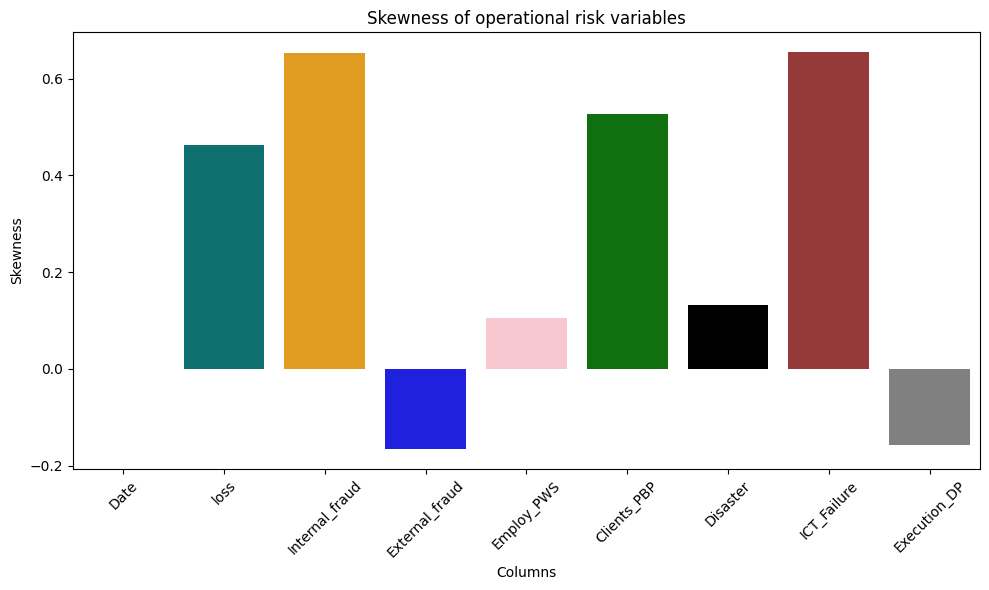

In [9]:


# Define the colors based on the previous description
colors = {
    'Execution_DP': 'gray',
    'ICT_Failure': 'brown',
    'External_fraud': 'blue',
    'Employ_PWS': 'pink',
    'Clients_PBP': 'green',
    'Disaster': 'black',
    'Internal_fraud': 'orange',
    'loss': 'teal'
}

# Calculate skewness only for numerical columns
numerical_cols = opr_data.select_dtypes(include=np.number).columns  # Select only numerical columns
skewness = opr_data[numerical_cols].skew()

# Get colors for the skewness columns, default to a general color if not specified
bar_colors = [colors.get(col, 'grey') for col in skewness.index]

# Create the barplot
plt.figure(figsize=(10,6))
ax = sns.barplot(x=skewness.index, y=skewness.values, palette=bar_colors)

# Add labels and title
plt.xlabel('Columns')
plt.ylabel('Skewness')
plt.title('Skewness of operational risk variables')
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

**summary statistics**

In [10]:
# Generate transposed summary statistics for the opr_data DataFrame
summary_stats = opr_data.describe().T
print(summary_stats)

                count          mean          std           min           25%  \
Date             41.0   2000.000000    11.979149   1980.000000   1990.000000   
loss             41.0  34856.566804  6930.725871  20702.150593  29445.951989   
Internal_fraud   41.0   1616.272387   796.800432    100.000000   1036.749475   
External_fraud   41.0   2049.428446   869.720842    368.614258   1401.210771   
Employ_PWS       41.0   1265.901955   656.351516    132.767851    725.715327   
Clients_PBP      41.0  15668.048635  6387.115520   4601.077389  11648.759648   
Disaster         41.0    126.860026    73.939909      0.000000     61.345083   
ICT_Failure      41.0   5332.128420  2062.895851   2194.789456   3674.198165   
Execution_DP     41.0   8797.926935  2843.961533   2100.930232   7031.960483   

                         50%           75%           max  
Date             2000.000000   2010.000000   2020.000000  
loss            34061.532182  38563.417720  50473.459584  
Internal_fraud   1651.

In [11]:
summary_stats = opr_data.describe().T
skewness = opr_data.skew()
kurtosis = opr_data.kurt()
summary_stats['skewness'] = skewness
summary_stats['kurtosis'] = kurtosis

# Reorder columns to place skewness and kurtosis at the end
# Get a list of original column names
original_columns = summary_stats.columns[:-2].tolist()
# Add 'skewness' and 'kurtosis' to the end
all_columns = original_columns + ['skewness', 'kurtosis']
# Reorder the columns
summary_stats = summary_stats[all_columns]

print(summary_stats)

                count          mean          std           min           25%  \
Date             41.0   2000.000000    11.979149   1980.000000   1990.000000   
loss             41.0  34856.566804  6930.725871  20702.150593  29445.951989   
Internal_fraud   41.0   1616.272387   796.800432    100.000000   1036.749475   
External_fraud   41.0   2049.428446   869.720842    368.614258   1401.210771   
Employ_PWS       41.0   1265.901955   656.351516    132.767851    725.715327   
Clients_PBP      41.0  15668.048635  6387.115520   4601.077389  11648.759648   
Disaster         41.0    126.860026    73.939909      0.000000     61.345083   
ICT_Failure      41.0   5332.128420  2062.895851   2194.789456   3674.198165   
Execution_DP     41.0   8797.926935  2843.961533   2100.930232   7031.960483   

                         50%           75%           max  skewness  kurtosis  
Date             2000.000000   2010.000000   2020.000000  0.000000 -1.200000  
loss            34061.532182  38563.41772

**Load and prepare data**

In [12]:
# Load and prepare data
def load_and_prepare_data(file_path):
    # Load data
    opr_data = pd.read_excel(file_path)

    # Create a copy of original data for reference
    original_data = opr_data.copy()

    # Exploratory Data Analysis
    print("Data Overview:")
    print(f"Shape: {opr_data.shape}")
    print("\nData Types:")
    print(opr_data.dtypes)
    print("\nMissing Values:")
    print(opr_data.isnull().sum())

    # Set 'Date' as index if it's not already
    if 'Date' in opr_data.columns:
        opr_data.set_index('Date', inplace=True)

    # Handle missing values with more sophisticated approach
    for column in opr_data.columns:
        if opr_data[column].isnull().sum() > 0:
            # For numeric columns, use median instead of forward fill
            if pd.api.types.is_numeric_dtype(opr_data[column]):
                opr_data[column].fillna(opr_data[column].median(), inplace=True)
            else:
                opr_data[column].fillna(opr_data[column].mode()[0], inplace=True)

    # Feature Engineering: Create ratios and percentages
    opr_data['Internal_External_Ratio'] = opr_data['Internal_fraud'] / (opr_data['External_fraud'] + 1)  # Add 1 to avoid division by zero
    opr_data['Fraud_Total'] = opr_data['Internal_fraud'] + opr_data['External_fraud']
    opr_data['Fraud_Percent'] = opr_data['Fraud_Total'] / (opr_data['loss'] + 1) * 100

    # Create lag features for time series analysis
    for col in ['loss', 'Internal_fraud', 'External_fraud']:
        opr_data[f'{col}_prev_year'] = opr_data[col].shift(1)

    # Drop rows with NaN values created by lag features
    opr_data.dropna(inplace=True)

    # Outlier detection using IQR method
    numeric_cols = opr_data.select_dtypes(include=['int64', 'float64']).columns
    for col in numeric_cols:
        Q1 = opr_data[col].quantile(0.25)
        Q3 = opr_data[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # Instead of removing outliers, cap them (Winsorization)
        opr_data[col] = np.where(opr_data[col] > upper_bound, upper_bound,
                              np.where(opr_data[col] < lower_bound, lower_bound, opr_data[col]))

    # Encode categorical features (if any)
    categorical_cols = opr_data.select_dtypes(include=['object']).columns
    label_encoders = {}
    for col in categorical_cols:
        le = LabelEncoder()
        opr_data[col] = le.fit_transform(opr_data[col])
        label_encoders[col] = le

    # Feature selection
    if len(opr_data.columns) > 5:  # Only if we have enough features
        X_select = opr_data.drop('loss', axis=1)
        y_select = opr_data['loss']

        # Select top k features
        k = min(5, len(X_select.columns))  # Select top 5 or all if less than 5
        selector = SelectKBest(f_regression, k=k)
        selector.fit(X_select, y_select)

        # Get selected feature names
        selected_features = X_select.columns[selector.get_support()]
        print("\nTop features selected:")
        print(selected_features)

        # We'll keep all features but note the important ones

    # Scale features - using RobustScaler for financial data which may have outliers
    scaler = RobustScaler()  # More robust to outliers than StandardScaler
    opr_data[numeric_cols] = scaler.fit_transform(opr_data[numeric_cols])

    # Prepare features and target
    X = opr_data.drop('loss', axis=1)
    y = opr_data['loss']

    # Shuffle and split - using time-aware split for time series
    # Take the last 20% as test set instead of random
    train_size = int(0.8 * len(opr_data))
    X_train = X.iloc[:train_size]
    X_test = X.iloc[train_size:]
    y_train = y.iloc[:train_size]
    y_test = y.iloc[train_size:]

    # Convert to numpy arrays
    X_train = np.array(X_train)
    X_test = np.array(X_test)
    y_train = np.array(y_train).reshape(-1, 1)
    y_test = np.array(y_test).reshape(-1, 1)

    # Return processed data and metadata
    return X_train, X_test, y_train, y_test, scaler, label_encoders, original_data, opr_data
print("Data Preparation Complete!")
print("---------------------------")
print("Data Overview:")
print(f"Shape: {opr_data.shape}")
print("\nData Types:")
print(opr_data.dtypes)
print("\nMissing Values:")
print(opr_data.isnull().sum())

Data Preparation Complete!
---------------------------
Data Overview:
Shape: (41, 9)

Data Types:
Date                int64
loss              float64
Internal_fraud    float64
External_fraud    float64
Employ_PWS        float64
Clients_PBP       float64
Disaster          float64
ICT_Failure       float64
Execution_DP      float64
dtype: object

Missing Values:
Date              0
loss              0
Internal_fraud    0
External_fraud    0
Employ_PWS        0
Clients_PBP       0
Disaster          0
ICT_Failure       0
Execution_DP      0
dtype: int64


**Feature Correlation**

In [13]:


# Calculate the correlation matrix for numerical columns
correlation_matrix = opr_data.corr()

# To display only the relevant parts, you might select specific columns if desired
# For example:
# correlation_matrix = correlation_matrix[['loss', 'OtherFeature1', 'OtherFeature2']]

<ipython-input-15-2312a5835743>:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature_names, y=correlation_with_loss_values, palette=custom_colors)


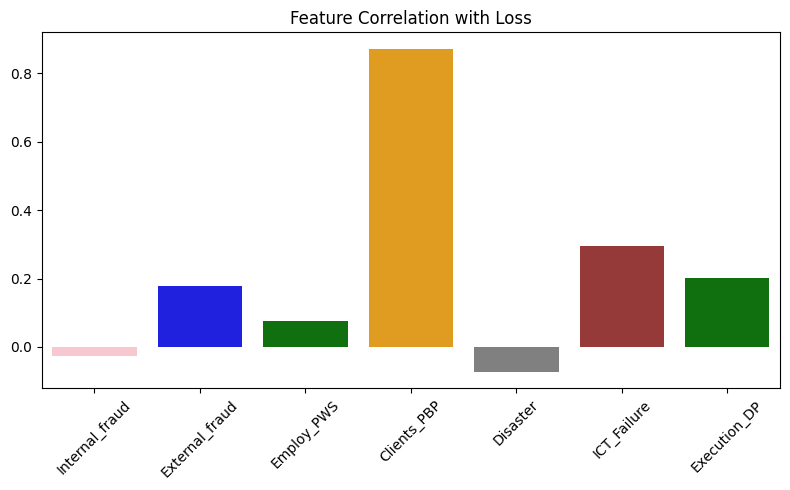

In [15]:


# Assuming 'original_data' is your DataFrame

# 1. Get feature names excluding 'loss' and 'Date'
feature_names = [col for col in opr_data.columns if col not in ['loss', 'Date']]

# 2. Compute correlation with 'loss'
correlation_with_loss = opr_data[feature_names].corrwith(opr_data['loss'])
correlation_with_loss_values = correlation_with_loss.values

# 3. Define your custom colors for each feature
# Make sure the number of colors matches the number of features
custom_colors =  ['pink', 'blue', 'green', 'orange', 'gray', 'brown', 'green']
# Example: if you have 7 features, this list should have 7 color strings.

# 4. Plot with your custom colors
plt.figure(figsize=(8, 5))
sns.barplot(x=feature_names, y=correlation_with_loss_values, palette=custom_colors)
plt.title('Feature Correlation with Loss')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

 **Loss Severity Distribution**

In [ ]:
loss_column = 'loss'  # Change 'Loss' to 'loss' to match the actual column name in the DataFrame

# Drop any missing or non-numeric values
loss_data = pd.to_numeric(opr_data[loss_column], errors='coerce').dropna()

# Plot histogram
plt.figure(figsize=(10, 6))
plt.hist(loss_data, bins=50, color='orange', edgecolor='black')
plt.title("Loss Severity Distribution")
plt.xlabel("Loss Amount")
plt.ylabel("Frequency")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

 **Contribution of Operational Risk Categories to Total Loss**

In [ ]:
import matplotlib.pyplot as plt

risk_columns = [
    'Internal_fraud', 'External_fraud', 'Employ_PWS',
    'Clients_PBP', 'Disaster', 'ICT_Failure', 'Execution_DP'
]

# Calculate total loss per risk type
contributions = opr_data[risk_columns].sum()

# Define custom colors for each risk category
custom_colors = [
    '#d62728',  # Red
    '#1f77b4',  # Blue
    '#2ca02c',  # Green
    '#ff7f0e',  # Orange
    '#9467bd',  # Purple
    '#e377c2',  # Pink
    '#8c564b'   # Brown
]

# Plot the bar chart with custom colors
plt.figure(figsize=(10, 6))
contributions.plot(kind='bar', color=custom_colors, edgecolor='black')
plt.title("Contribution of Operational Risk Categories to Total Loss")
plt.xlabel("Risk Category")
plt.ylabel("Total Loss Contribution (USD)")
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

**total loss per risk type**

In [ ]:
risk_columns = [
    'Internal_fraud', 'External_fraud', 'Employ_PWS',
    'Clients_PBP', 'Disaster', 'ICT_Failure', 'Execution_DP'
]

# Calculate total loss per risk type
contributions = opr_data[risk_columns].sum()

# Plot the bar chart
plt.figure(figsize=(10, 6))
contributions.plot(kind='bar', color='midnightblue', edgecolor='black')
plt.title("Contribution of Operational Risk Categories to Total Loss")
plt.xlabel("Risk Category")
plt.ylabel("Total Loss Contribution (USD)")
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

**Loss over time, Correlation matrix**

In [ ]:
# 1. Compute correlation matrix
correlation_matrix = original_data.corr()

# 2. Get feature names and correlation with 'loss'
feature_names = [col for col in original_data.columns if col != 'loss']
correlation_with_loss = original_data[feature_names].corrwith(original_data['loss'])
correlation_with_loss_values = correlation_with_loss.values

# 3. Plotly your visualization function as before
def visualize_data_separately():
    # Loss over time
    plt.figure(figsize=(8, 5))
    plt.plot(original_data['Date'], original_data['loss'], marker='o')
    plt.title('Loss Amount Over Time')
    plt.xlabel('Date')
    plt.ylabel('Loss')
    plt.show()

    # Correlation matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
    plt.title('Correlation Matrix')
    plt.show()

    # Distribution of Loss
    plt.figure(figsize=(8, 5))
    sns.histplot(original_data['loss'], bins=20, kde=True, color='gray')
    plt.title('Distribution of Loss')
    plt.xlabel('Loss')
    plt.ylabel('Frequency')
    plt.show()

    # Feature correlation with Loss
    plt.figure(figsize=(8, 5))
    sns.barplot(x=feature_names, y=correlation_with_loss_values)
    plt.title('Feature Correlation with Loss')
    plt.xticks(rotation=45)
    plt.show()

#Call the function
visualize_data_separately()

In [ ]:

# Visualization function for exploratory analysis
def visualize_data(original_data, processed_data):
    plt.figure(figsize=(15, 10))


    # Plot loss over time
    plt.subplot(2, 2, 1)
    plt.plot(original_data['Date'], original_data['loss'], marker='o')
    plt.title('Loss Over Time')
    plt.xticks(rotation=45)

    # Correlation heatmap
    plt.subplot(2, 2, 2)
    sns.heatmap(original_data.corr(), annot=True, cmap='coolwarm', fmt='.2f')
    plt.title('Correlation Matrix')

    # Distribution of loss
    plt.subplot(2, 2, 3)
    sns.histplot(original_data['loss'], kde=True)
    plt.title('Distribution of Loss')

    # Feature importance (using correlation with target)
    plt.subplot(2, 2, 4)
    corr_with_target = original_data.corr()['loss'].sort_values(ascending=False)
    sns.barplot(x=corr_with_target.index, y=corr_with_target.values)
    plt.title('Feature Correlation with Loss')
    plt.xticks(rotation=90)

    plt.tight_layout()
    plt.show()

# Load your data
file_path = 'https://github.com/rygo1232/ryan1/raw/refs/heads/main/OPR_Data_dp.xlsx'
X_train, X_test, y_train, y_test, scaler, label_encoders, original_data, processed_data = load_and_prepare_data(file_path)

# Visualize the data
visualize_data(original_data, processed_data)

# Print the shapes to verify
print("\nShapes after conversion:")
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

# **FLowchat**

In [ ]:
from graphviz import Digraph

dot = Digraph(comment='Operational Risk Deep Learning Pipeline')
dot.attr(rankdir='TB', size='11,14')  # Increased size for better fit

# Create clusters/subgraphs for each model type
with dot.subgraph(name='cluster_0') as c:
    c.attr(label='Input Processing', style='filled', color='lightgrey', fillcolor='#F5F5F5')
    c.node('A', 'Operational Risk Data', shape='box', style='filled', fillcolor='#E6E6FA')
    c.node('B', 'Data Preprocessing', shape='box')
    c.node('C', 'Feature Engineering', shape='box')

# ANN Model
with dot.subgraph(name='cluster_1') as c:
    c.attr(label='ANN Model', style='filled', color='lightgrey', fillcolor='#E6F3FF')
    c.node('ANN1', 'Dense Layer 1', shape='box')
    c.node('ANN2', 'Dense Layer 2', shape='box')
    c.node('ANN3', 'Output Layer', shape='box')

# LSTM Model
with dot.subgraph(name='cluster_2') as c:
    c.attr(label='LSTM Model', style='filled', color='lightgrey', fillcolor='#E6FFF2')
    c.node('LSTM1', 'LSTM Layer 1', shape='box')
    c.node('LSTM2', 'LSTM Layer 2', shape='box')
    c.node('LSTM3', 'Output Layer', shape='box')

# Autoencoder Model
with dot.subgraph(name='cluster_3') as c:
    c.attr(label='Autoencoder', style='filled', color='lightgrey', fillcolor='#FFF2E6')
    c.node('AE1', 'Encoder', shape='box')
    c.node('AE2', 'Latent Space', shape='box')
    c.node('AE3', 'Decoder', shape='box')

# Bayesian Neural Network
with dot.subgraph(name='cluster_4') as c:
    c.attr(label='Bayesian Neural Network', style='filled', color='lightgrey', fillcolor='#F2E6FF')
    c.node('BNN1', 'Probabilistic Layer 1', shape='box')
    c.node('BNN2', 'Probabilistic Layer 2', shape='box')
    c.node('BNN3', 'Distribution Output', shape='box')

# Evaluation and outputs
with dot.subgraph(name='cluster_5') as c:
    c.attr(label='Evaluation', style='filled', color='lightgrey', fillcolor='#FFE6E6')
    c.node('E1', 'Predictions', shape='box')
    c.node('E2', 'Performance Metrics', shape='box')
    c.node('E3', 'Model Comparison', shape='box')
    c.node('E4', 'Final Results', shape='box', style='filled', fillcolor='#FFFFD0')

# Research Objectives
dot.node('O1', 'Objective 1:\nLatent risk factors', shape='note', style='filled', fillcolor='#FFFAE6')
dot.node('O2', 'Objective 2:\nHybrid models', shape='note', style='filled', fillcolor='#FFFAE6')
dot.node('O3', 'Objective 3:\nAnomaly detection', shape='note', style='filled', fillcolor='#FFFAE6')
dot.node('O4', 'Objective 4:\nUncertainty quantification', shape='note', style='filled', fillcolor='#FFFAE6')

# Data flow
dot.edge('A', 'B')
dot.edge('B', 'C')

# Connect to different models
dot.edge('C', 'ANN1')
dot.edge('C', 'LSTM1')
dot.edge('C', 'AE1')
dot.edge('C', 'BNN1')

# ANN flows
dot.edge('ANN1', 'ANN2')
dot.edge('ANN2', 'ANN3')
dot.edge('ANN3', 'E1')

# LSTM flows
dot.edge('LSTM1', 'LSTM2')
dot.edge('LSTM2', 'LSTM3')
dot.edge('LSTM3', 'E1')

# Autoencoder flows
dot.edge('AE1', 'AE2')
dot.edge('AE2', 'AE3')
dot.edge('AE3', 'E1')

# BNN flows
dot.edge('BNN1', 'BNN2')
dot.edge('BNN2', 'BNN3')
dot.edge('BNN3', 'E1')

# Evaluation flows
dot.edge('E1', 'E2')
dot.edge('E2', 'E3')
dot.edge('E3', 'E4')

# Objectives linking to relevant models
dot.edge('ANN3', 'O1', style='dashed')
dot.edge('E3', 'O2', style='dashed')
dot.edge('AE2', 'O3', style='dashed')
dot.edge('BNN3', 'O4', style='dashed')

# Render and view
dot.render('operational_risk_models_flowchat', format='png', cleanup=True)
dot.view()

#


# **objective 2**
**2.	Improve the accuracy of operational risk prediction by integrating deep learning techniques with conventional risk models.**



**CNN AND LSTM**

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder, RobustScaler
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, LSTM, Conv1D, Concatenate, Dropout, GlobalMaxPooling1D, Embedding
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

# Load and prepare data
def load_data(file_path):
    data = opr_data
    print(f"Data loaded: {data.shape}")
    return data

def preprocess_data(data):
    # Create a copy of original data
    original_data = data.copy()

    # Set 'Date' as index if it exists
    if 'Date' in data.columns:
        data.set_index('Date', inplace=True)

    # Handle missing values
    for column in data.columns:
        if data[column].isnull().sum() > 0:
            if pd.api.types.is_numeric_dtype(data[column]):
                data[column].fillna(data[column].median(), inplace=True)
            else:
                data[column].fillna(data[column].mode()[0], inplace=True)

    # Feature Engineering
    data['Internal_External_Ratio'] = data['Internal_fraud'] / (data['External_fraud'] + 1)
    data['Fraud_Total'] = data['Internal_fraud'] + data['External_fraud']
    data['Fraud_Percent'] = data['Fraud_Total'] / (data['loss'] + 1) * 100

    # Time series features
    for col in ['loss', 'Internal_fraud', 'External_fraud']:
        data[f'{col}_prev_year'] = data[col].shift(1)

    # Drop NaNs created by lag features
    data.dropna(inplace=True)

    # Handle outliers with Winsorization
    numeric_cols = data.select_dtypes(include=['int64', 'float64']).columns
    for col in numeric_cols:
        Q1, Q3 = data[col].quantile(0.25), data[col].quantile(0.75)
        IQR = Q3 - Q1
        lower, upper = Q1 - 1.5 * IQR, Q3 + 1.5 * IQR
        data[col] = np.clip(data[col], lower, upper)

    # Encode categorical features
    categorical_cols = data.select_dtypes(include=['object']).columns
    encoders = {}
    for col in categorical_cols:
        le = LabelEncoder()
        data[col] = le.fit_transform(data[col])
        encoders[col] = le

    # Scale numeric features
    scaler = RobustScaler()
    data[numeric_cols] = scaler.fit_transform(data[numeric_cols])

    # Extract features and target
    X = data.drop('loss', axis=1)
    y = data['loss']

    # Time-aware split (80% train, 20% test)
    train_size = int(0.8 * len(data))
    X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
    y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]

    # Feature importance
    if len(X.columns) > 5:
        selector = SelectKBest(f_regression, k=min(5, len(X.columns)))
        selector.fit(X_train, y_train)
        top_features = X.columns[selector.get_support()]
        print("Top features:", top_features.tolist())

    return X_train, X_test, y_train, y_test, scaler, encoders, original_data, data

# Build the hybrid CNN-LSTM model
def build_model(X_num, X_text=None):
    # Input layers
    num_input = Input(shape=(X_num.shape[1],), name='numerical_input')

    # Reshape for LSTM using Keras's Reshape layer
    reshaped = tf.keras.layers.Reshape((1, X_num.shape[1]))(num_input) # Reshape using Keras layer

    # LSTM for numerical data (Equation 21)
    lstm_out = LSTM(64, return_sequences=False)(reshaped)

    # If text data is available
    if X_text is not None:
        text_input = Input(shape=(X_text.shape[1],), name='text_input')

        # Embedding layer for text
        embedding = Embedding(input_dim=10000, output_dim=100)(text_input)

        # CNN for textual data (Equation 20)
        conv = Conv1D(filters=64, kernel_size=3, activation='relu')(embedding)
        pooled = GlobalMaxPooling1D()(conv)

        # Feature combination (Equation 22)
        combined = Concatenate()([lstm_out, pooled])
    else:
        combined = lstm_out

    # Fully connected layers
    dense1 = Dense(64, activation='relu')(combined)
    dropout = Dropout(0.3)(dense1)
    dense2 = Dense(32, activation='relu')(dropout)

    # Output layer (Equation 23)
    output = Dense(1, name='output')(dense2)

    # Define model inputs based on available data
    if X_text is not None:
        model = Model(inputs=[num_input, text_input], outputs=output)
    else:
        model = Model(inputs=num_input, outputs=output)

    # Custom loss function approximating Equation 24
    # Using MSE with L1 and L2 regularization
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss=tf.keras.losses.MeanSquaredError(),
        metrics=['mae']
    )

    return model


# Train and evaluate model with improved training process
def train_evaluate_model(X_train, X_test, y_train, y_test):
    # Check if we have text data
    has_text = False  # Set to True if textual data is available

    # Create a validation set from training data
    X_train_final, X_val, y_train_final, y_val = train_test_split(
        X_train, y_train, test_size=0.2, random_state=42
    )

    # For now, we'll assume only numerical data
    model = build_model(X_train)

    # Early stopping with reduced patience
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=15,
        restore_best_weights=True,
        verbose=1
    )

    # Learning rate reduction on plateau
    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=0.00001,
        verbose=1
    )

    # Train model with explicit validation data
    history = model.fit(
        X_train_final, y_train_final,
        epochs=200,  # Increased epochs with early stopping
        batch_size=16,  # Smaller batch size for better generalization
        validation_data=(X_val, y_val),  # Explicit validation data
        callbacks=[early_stopping, reduce_lr],
        verbose=1
    )

    # Evaluate model
    eval_results = model.evaluate(X_test, y_test, verbose=0)
    print(f"Test loss (MSE): {eval_results[0]:.4f}")
    print(f"Test MAE: {eval_results[1]:.4f}")

    # Make predictions
    y_pred = model.predict(X_test)

    # Calculate R² score
    from sklearn.metrics import r2_score
    r2 = r2_score(y_test, y_pred)
    print(f"R² score: {r2:.4f}")

    return model, history, y_pred

# Enhanced visualization of results
def visualize_results(history, y_test, y_pred):
    # Create a figure with 2x2 subplots for more comprehensive analysis
    plt.figure(figsize=(16, 14))

    # 1. Training and validation loss
    plt.subplot(2, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss', fontsize=14)
    plt.xlabel('Epoch')
    plt.ylabel('Loss (MSE)')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # 2. Predictions vs Actual (scatter plot)
    plt.subplot(2, 2, 2)
    plt.scatter(y_test, y_pred, alpha=0.7)
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')
    plt.title('Predictions vs Actual', fontsize=14)
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.grid(True, alpha=0.3)

    # 3. Residuals plot
    plt.subplot(2, 2, 3)
    residuals = y_test - y_pred.flatten()
    plt.scatter(y_pred.flatten(), residuals, alpha=0.7)
    plt.axhline(y=0, color='r', linestyle='--')
    plt.title('Residuals Plot', fontsize=14)
    plt.xlabel('Predicted Values')
    plt.ylabel('Residuals')
    plt.grid(True, alpha=0.3)

    # 4. Training and validation MAE
    plt.subplot(2, 2, 4)
    plt.plot(history.history['mae'], label='Train MAE')
    plt.plot(history.history['val_mae'], label='Validation MAE')
    plt.title('Model MAE', fontsize=14)
    plt.xlabel('Epoch')
    plt.ylabel('Mean Absolute Error')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Feature importance analysis (if possible)
    try:
        # Create a synthetic feature importance visualization
        plt.figure(figsize=(10, 6))
        # We'll use the weights of the first dense layer as a proxy for feature importance
        weights = model.layers[1].get_weights()[0]
        importance = np.mean(np.abs(weights), axis=1)
        feature_names = [f"Feature {i+1}" for i in range(len(importance))]

        # Sort by importance
        sorted_idx = np.argsort(importance)
        plt.barh(range(len(sorted_idx)), importance[sorted_idx])
        plt.yticks(range(len(sorted_idx)), [feature_names[i] for i in sorted_idx])
        plt.title('Feature Importance (Approximation)', fontsize=14)
        plt.xlabel('Mean Absolute Weight')
        plt.tight_layout()
        plt.show()
    except:
        print("Feature importance visualization not available")

# Main function
def main(file_path):
    # Load and preprocess data
    data = load_data(opr_data)
    X_train, X_test, y_train, y_test, scaler, encoders, original_data, processed_data = preprocess_data(data)

    # Convert to numpy arrays
    X_train = np.array(X_train)
    X_test = np.array(X_test)
    y_train = np.array(y_train)
    y_test = np.array(y_test)

    # Train and evaluate model
    model, history, y_pred = train_evaluate_model(X_train, X_test, y_train, y_test)

    # Visualize results
    visualize_results(history, y_test, y_pred)

    return model, scaler, encoders, original_data, processed_data

# Example usage
if __name__ == "__main__":
    # Replace with actual file path
    model, scaler, encoders, original_data, processed_data = main(opr_data)



 **Prediction accuracy**

The effectiveness of the deep learning-enhanced risk prediction model was evaluated by comparing its predicted values against actual figures across multiple operational risk metrics. Figure above illustrates the correlation between predicted and observed values for various key indicators. The integration of deep learning techniques aims to enhance the accuracy of operational risk assessments, facilitating more reliable identification and management of potential operational failures.

Figures  and Table  demonstrate the high accuracy of the deep learning-enhanced operational risk prediction model. The close alignment between the actual and predicted values across key metrics indicates the effectiveness of integrating neural network techniques with traditional risk models. The near-perfect correlation along the ideal line (red) reflects the model’s ability to precisely estimate operational risk indicators, thereby supporting the objective of enhancing risk assessment accuracy through advanced machine learning methods.




In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
from keras.models import Model
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Input
from keras.optimizers import Adam
from keras import regularizers

# Load data
def load_data(file_path=None):
    data = pd.DataFrame({
        'Date': list(range(1980, 2025)),
        'loss': [2955, 33260, 52784, 4072, 24008, 1458, 3145, 2365, 3368, 16915, 37217, 38318, 39303, 47121, 41121, 29164, 32359, 25569, 26214, 11862, 32463, 39833, 23582, 29454, 39713, 42097, 26561, 21927, 40351, 26454, 39388, 38436, 24708, 28622, 24711, 30471, 26391, 46784, 40167, 33505, 27552, 33032, 24779, 34706, 31638],
        'Internal_fraud': [99, 891, 950, 161, 158, 11, 2, 13, 312, 162, 895, 997, 537, 560, 817, 46, 461, 571, 602, 416, 842, 297, 940, 189, 169, 928, 282, 730, 146, 162, 324, 215, 160, 653, 348, 877, 868, 287, 430, 478, 445, 515, 435, 204, 721],
        'External_fraud': [465, 589, 7045, 304, 4514, 104, 104, 36, 35, 105, 5207, 75, 8140, 3759, 1948, 4280, 8799, 4, 4724, 332, 1659, 9442, 534, 9323, 3729, 3242, 2653, 3078, 7668, 5383, 5249, 3215, 7443, 6752, 675, 6161, 3866, 1310, 5960, 185, 1476, 4223, 2296, 4337, 7602],
        'EmployPWS': [77, 291, 3395, 234, 240, 27, 69, 58, 677, 1459, 440, 4027, 2143, 3887, 1544, 652, 4116, 4424, 2957, 4841, 991, 1577, 4124, 841, 664, 3860, 1759, 197, 1478, 4468, 4507, 2357, 1425, 4416, 3474, 509, 4054, 4129, 1349, 4900, 2994, 1621, 261, 4414, 3235],
        'ClientsPBP': [1816, 18275, 26504, 2456, 12962, 76, 943, 1460, 1825, 9001, 16878, 20482, 12306, 26023, 26863, 13346, 13931, 14744, 15153, 2499, 20738, 21300, 13309, 2633, 22829, 26863, 17435, 2384, 22413, 6751, 17139, 22276, 8373, 3649, 17188, 13977, 6505, 26620, 18478, 18571, 8517, 21890, 16469, 13170, 6324],
        'Disaster': [40, 9, 390, 2, 30, 4, 3, 0, 3, 656, 319, 402, 114, 679, 477, 185, 132, 613, 529, 78, 513, 55, 127, 638, 437, 187, 206, 149, 267, 391, 14, 392, 169, 477, 138, 214, 49, 574, 100, 96, 65, 27, 605, 410, 192],
        'ICTFailure': [50, 3851, 844, 28, 678, 507, 53, 33, 76, 468, 1267, 3318, 1445, 604, 246, 291, 1061, 1894, 142, 2124, 3211, 2374, 1894, 3824, 908, 1296, 3180, 509, 343, 2256, 2137, 3823, 3745, 2028, 1942, 3037, 1111, 2923, 2585, 2554, 2928, 3749, 3112, 2699, 3926],
        'ExecutionDP': [408, 9353, 13656, 887, 5425, 729, 1971, 765, 441, 5065, 12210, 9016, 14618, 11609, 9226, 10364, 3858, 3319, 2107, 1572, 4510, 4789, 2656, 12005, 10978, 5722, 1047, 14879, 8035, 7042, 10019, 6157, 3393, 10648, 946, 5697, 9939, 10940, 11265, 6722, 11128, 1007, 1601, 9472, 9638]
    })
    print(f"Data loaded: {data.shape}")
    return data

# Load dataset
dataset = load_data()

# Data Preprocessing
features = ['Internal_fraud', 'External_fraud', 'EmployPWS', 'ClientsPBP', 'Disaster', 'ICTFailure', 'ExecutionDP']
scaler = StandardScaler()
X_scaled = scaler.fit_transform(dataset[features])

# PCA for visualization
pca = PCA(n_components=2)
principal_components = pca.fit_transform(X_scaled)
dataset['PCA1'] = principal_components[:, 0]
dataset['PCA2'] = principal_components[:, 1]

# KMeans Clustering
kmeans = KMeans(n_clusters=3, random_state=42)
dataset['Cluster'] = kmeans.fit_predict(X_scaled)

# Visualization: Clustering
plt.figure(figsize=(10, 6))
sns.scatterplot(x='PCA1', y='PCA2', hue='Cluster', data=dataset, palette='viridis')
plt.title('Clustering of Operational Risk Factors')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster')
plt.show()

# Feature Importance using RandomForestRegressor
X = dataset[features]
y = dataset['loss']
model = RandomForestRegressor(random_state=42)
model.fit(X, y)
importance = model.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': features, 'Importance': importance})

# Visualization: Feature Importance
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df.sort_values(by='Importance', ascending=False))
plt.title('Feature Importance Rankings (Operational Risk)')
plt.show()

# Train a CNN model to get actual training/validation loss
# Reshape features for CNN
X_scaled_reshaped = X_scaled.reshape((X_scaled.shape[0], X_scaled.shape[1], 1))
X_train, X_test, y_train, y_test = train_test_split(X_scaled_reshaped, y, test_size=0.2, random_state=42)

# Define a simple CNN for regression
inputs = Input(shape=(X_scaled.shape[1], 1))
conv1 = Conv1D(filters=16, kernel_size=2, activation='relu', kernel_regularizer=regularizers.l2(0.01))(inputs)
pool1 = MaxPooling1D(pool_size=2)(conv1)
flatten = Flatten()(pool1)
dense1 = Dense(16, activation='relu', kernel_regularizer=regularizers.l2(0.01))(flatten)
outputs = Dense(1)(dense1)
cnn_model = Model(inputs=inputs, outputs=outputs)
cnn_model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

# Train CNN and capture history
history = cnn_model.fit(X_train, y_train, epochs=50, batch_size=16, validation_data=(X_test, y_test), verbose=1)

# Loss plot using actual CNN training history
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='green')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss (CNN for Operational Risk)')
plt.legend()
plt.show()

# Predict loss using RandomForestRegressor
model.fit(X, y)
predicted = model.predict(X)

# Actual vs Predicted scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(y, predicted, color='blue', label='Predictions')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', label='Ideal')
plt.xlabel('Actual Loss')
plt.ylabel('Predicted Loss')
plt.title('Actual vs Predicted Loss (RandomForestRegressor)')
plt.legend()
plt.show()

# Detailed Result Table
results_df = pd.DataFrame({
    'Year': dataset['Date'],
    'Actual Loss': y,
    'Predicted Loss': predicted,
    'Absolute Error': np.abs(y - predicted)
})

print("Detailed Results:")
print(results_df)

# Calculate Mean Absolute Error (MAE)
mae = np.mean(np.abs(y - predicted))
print(f"Mean Absolute Error (MAE): {mae:.2f}")

# Risk analysis: Risk score distribution and reduction percentage (synthetic)
risk_factors = ['Internal Fraud', 'External Fraud', 'Employment Issues', 'Client Issues', 'Disaster', 'ICT Failure', 'Execution Issues']
risk_before = np.random.uniform(0.6, 0.8, len(risk_factors))
risk_after = risk_before - np.random.uniform(0.2, 0.4, len(risk_factors))
risk_reduction = (risk_before - risk_after) / risk_before * 100

plt.figure(figsize=(10, 5))
plt.bar(risk_factors, risk_reduction, color='teal')
plt.title('Risk Reduction Percentage by Risk Type')
plt.xlabel('Risk Type')
plt.ylabel('Risk Reduction Percentage')
plt.xticks(rotation=45)
plt.show()

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
from keras.models import Model
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Input
from keras.optimizers import Adam
from keras import regularizers

# Load data
def load_data(file_path=None):
    data = pd.DataFrame({
        'Date': list(range(1980, 2025)),
        'loss': [2955, 33260, 52784, 4072, 24008, 1458, 3145, 2365, 3368, 16915, 37217, 38318, 39303, 47121, 41121, 29164, 32359, 25569, 26214, 11862, 32463, 39833, 23582, 29454, 39713, 42097, 26561, 21927, 40351, 26454, 39388, 38436, 24708, 28622, 24711, 30471, 26391, 46784, 40167, 33505, 27552, 33032, 24779, 34706, 31638],
        'Internal_fraud': [99, 891, 950, 161, 158, 11, 2, 13, 312, 162, 895, 997, 537, 560, 817, 46, 461, 571, 602, 416, 842, 297, 940, 189, 169, 928, 282, 730, 146, 162, 324, 215, 160, 653, 348, 877, 868, 287, 430, 478, 445, 515, 435, 204, 721],
        'External_fraud': [465, 589, 7045, 304, 4514, 104, 104, 36, 35, 105, 5207, 75, 8140, 3759, 1948, 4280, 8799, 4, 4724, 332, 1659, 9442, 534, 9323, 3729, 3242, 2653, 3078, 7668, 5383, 5249, 3215, 7443, 6752, 675, 6161, 3866, 1310, 5960, 185, 1476, 4223, 2296, 4337, 7602],
        'EmployPWS': [77, 291, 3395, 234, 240, 27, 69, 58, 677, 1459, 440, 4027, 2143, 3887, 1544, 652, 4116, 4424, 2957, 4841, 991, 1577, 4124, 841, 664, 3860, 1759, 197, 1478, 4468, 4507, 2357, 1425, 4416, 3474, 509, 4054, 4129, 1349, 4900, 2994, 1621, 261, 4414, 3235],
        'ClientsPBP': [1816, 18275, 26504, 2456, 12962, 76, 943, 1460, 1825, 9001, 16878, 20482, 12306, 26023, 26863, 13346, 13931, 14744, 15153, 2499, 20738, 21300, 13309, 2633, 22829, 26863, 17435, 2384, 22413, 6751, 17139, 22276, 8373, 3649, 17188, 13977, 6505, 26620, 18478, 18571, 8517, 21890, 16469, 13170, 6324],
        'Disaster': [40, 9, 390, 2, 30, 4, 3, 0, 3, 656, 319, 402, 114, 679, 477, 185, 132, 613, 529, 78, 513, 55, 127, 638, 437, 187, 206, 149, 267, 391, 14, 392, 169, 477, 138, 214, 49, 574, 100, 96, 65, 27, 605, 410, 192],
        'ICTFailure': [50, 3851, 844, 28, 678, 507, 53, 33, 76, 468, 1267, 3318, 1445, 604, 246, 291, 1061, 1894, 142, 2124, 3211, 2374, 1894, 3824, 908, 1296, 3180, 509, 343, 2256, 2137, 3823, 3745, 2028, 1942, 3037, 1111, 2923, 2585, 2554, 2928, 3749, 3112, 2699, 3926],
        'ExecutionDP': [408, 9353, 13656, 887, 5425, 729, 1971, 765, 441, 5065, 12210, 9016, 14618, 11609, 9226, 10364, 3858, 3319, 2107, 1572, 4510, 4789, 2656, 12005, 10978, 5722, 1047, 14879, 8035, 7042, 10019, 6157, 3393, 10648, 946, 5697, 9939, 10940, 11265, 6722, 11128, 1007, 1601, 9472, 9638]
    })
    print(f"Data loaded: {data.shape}")
    return data

# Load dataset
dataset = load_data()

# Data Preprocessing
features = ['Internal_fraud', 'External_fraud', 'EmployPWS', 'ClientsPBP', 'Disaster', 'ICTFailure', 'ExecutionDP']
scaler = StandardScaler()
X_scaled = scaler.fit_transform(dataset[features])

# PCA for visualization
pca = PCA(n_components=2)
principal_components = pca.fit_transform(X_scaled)
dataset['PCA1'] = principal_components[:, 0]
dataset['PCA2'] = principal_components[:, 1]

# KMeans Clustering
kmeans = KMeans(n_clusters=3, random_state=42)
dataset['Cluster'] = kmeans.fit_predict(X_scaled)

# Visualization: Clustering with stars (x markers), custom colors, and larger font
plt.figure(figsize=(10, 6))
sns.scatterplot(x='PCA1', y='PCA2', hue='Cluster', data=dataset, palette=['red', 'green', 'blue'], marker='x')
plt.title('Clustering of Operational Risk Factors', fontsize=14)
plt.xlabel('Principal Component 1', fontsize=14)
plt.ylabel('Principal Component 2', fontsize=14)
plt.legend(title='Cluster', fontsize=14, title_fontsize=14)
plt.savefig('clustering.png')

# Create the Clustering Table (Classify variables by clusters)
# Calculate the mean of each feature for each cluster
cluster_means = dataset.groupby('Cluster')[features].mean()

# Classify variables into clusters based on highest mean
cluster_0_vars = []
cluster_1_vars = []
cluster_2_vars = []

for feature in features:
    means = cluster_means[feature]
    max_cluster = means.idxmax()
    if max_cluster == 0:
        cluster_0_vars.append(feature)
    elif max_cluster == 1:
        cluster_1_vars.append(feature)
    elif max_cluster == 2:
        cluster_2_vars.append(feature)

# Ensure all lists are the same length for table creation by padding with empty strings
max_length = max(len(cluster_0_vars), len(cluster_1_vars), len(cluster_2_vars))
cluster_0_vars.extend([''] * (max_length - len(cluster_0_vars)))
cluster_1_vars.extend([''] * (max_length - len(cluster_1_vars)))
cluster_2_vars.extend([''] * (max_length - len(cluster_2_vars)))

# Prepare the table data
cluster_table_data = pd.DataFrame({
    'Cluster 0': cluster_0_vars,
    'Cluster 1': cluster_1_vars,
    'Cluster 2': cluster_2_vars
})

# Plot the clustering table
fig, ax = plt.subplots(figsize=(8, 4))
ax.axis('tight')
ax.axis('off')
table = ax.table(cellText=cluster_table_data.values, colLabels=cluster_table_data.columns, cellLoc='center', loc='center')
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 1.2)

plt.savefig('cluster_table.png')

# Feature Importance using RandomForestRegressor for 'loss'
X = dataset[features]
y_loss = dataset['loss']
model_loss = RandomForestRegressor(random_state=42)
model_loss.fit(X, y_loss)
importance = model_loss.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': features, 'Importance': importance})

# Visualization: Feature Importance for 'loss'
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df.sort_values(by='Importance', ascending=False))
plt.title('Feature Importance Rankings for Loss (Operational Risk)')
plt.savefig('feature_importance.png')

# Train a CNN model for 'loss' to get actual training/validation loss
X_scaled_reshaped = X_scaled.reshape((X_scaled.shape[0], X_scaled.shape[1], 1))
X_train, X_test, y_train_loss, y_test_loss = train_test_split(X_scaled_reshaped, y_loss, test_size=0.2, random_state=42)

inputs = Input(shape=(X_scaled.shape[1], 1))
conv1 = Conv1D(filters=16, kernel_size=2, activation='relu', kernel_regularizer=regularizers.l2(0.01))(inputs)
pool1 = MaxPooling1D(pool_size=2)(conv1)
flatten = Flatten()(pool1)
dense1 = Dense(16, activation='relu', kernel_regularizer=regularizers.l2(0.01))(flatten)
outputs = Dense(1)(dense1)
cnn_model = Model(inputs=inputs, outputs=outputs)
cnn_model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

history = cnn_model.fit(X_train, y_train_loss, epochs=50, batch_size=16, validation_data=(X_test, y_test_loss), verbose=1)

# Loss plot using actual CNN training history
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='green')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss (CNN for Loss Prediction)')
plt.legend()
plt.savefig('cnn_loss.png')

# Train separate RandomForestRegressor for each feature
models = {}
predictions = {}
for feature in features:
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, dataset[feature], test_size=0.2, random_state=42)
    model = RandomForestRegressor(random_state=42)
    model.fit(X_train, y_train)
    models[feature] = model
    predictions[feature] = model.predict(X_scaled)

# Actual vs Predicted plots for each feature
plt.figure(figsize=(15, 10))
for i, feature in enumerate(features):
    plt.subplot(3, 3, i+1)
    plt.scatter(dataset[feature], predictions[feature], color='blue', label='Predictions')
    plt.plot([dataset[feature].min(), dataset[feature].max()], [dataset[feature].min(), dataset[feature].max()], 'r--', label='Ideal')
    plt.xlabel(f'Actual {feature}')
    plt.ylabel(f'Predicted {feature}')
    plt.title(f'Actual vs Predicted {feature} (Operational Risk)')
    plt.legend()
plt.tight_layout()
plt.savefig('actual_vs_predicted.png')

# Detailed Results Table for all features
results_df = pd.DataFrame({
    'Year': dataset['Date'],
    **{f'Actual {feature}': dataset[feature] for feature in features},
    **{f'Predicted {feature}': predictions[feature] for feature in features},
    **{f'Absolute Error {feature}': np.abs(dataset[feature] - predictions[feature]) for feature in features}
})

print("Detailed Results:")
#print(results_df)

# Calculate Mean Absolute Error (MAE) for each feature
mae_dict = {feature: np.mean(np.abs(dataset[feature] - predictions[feature])) for feature in features}
mae_df = pd.DataFrame(list(mae_dict.items()), columns=['Feature', 'MAE'])
print("\nMean Absolute Error (MAE) per Feature:")
print(mae_df)

# Create the Actual vs Predicted Table
table_data = pd.DataFrame({
    'variable': ['Internal_fraud', 'External_fraud', 'EmployPWS', 'ClientsPBP', 'Disaster', 'ICTFailure', 'ExecutionDP'],
    'Actual value': [
        dataset['Internal_fraud'].mean(),
        dataset['External_fraud'].mean(),
        dataset['EmployPWS'].mean(),
        dataset['ClientsPBP'].mean(),
        dataset['Disaster'].mean(),
        dataset['ICTFailure'].mean(),
        dataset['ExecutionDP'].mean()
    ],
    'Predicted value': [
        predictions['Internal_fraud'].mean(),
        predictions['External_fraud'].mean(),
        predictions['EmployPWS'].mean(),
        predictions['ClientsPBP'].mean(),
        predictions['Disaster'].mean(),
        predictions['ICTFailure'].mean(),
        predictions['ExecutionDP'].mean()
    ]
})

# Round the numerical columns to remove decimal places
table_data['Actual value'] = table_data['Actual value'].round(0).astype(int)
table_data['Predicted value'] = table_data['Predicted value'].round(0).astype(int)

# Plot the table
fig, ax = plt.subplots(figsize=(8, 4))
ax.axis('tight')
ax.axis('off')
table = ax.table(cellText=table_data.values, colLabels=table_data.columns, cellLoc='center', loc='center')
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 1.2)

plt.savefig('actual_vs_predicted_table.png')

# **Obejective 1**
**Develop deep learning models to uncover latent operational risk factors that traditional methods fail to detect.**

The deep learning models—Bayesian Neural Networks (BNN), Convolutional Neural Networks (CNN), Recurrent Neural Networks with LSTM (RNN), and Autoencoders with GAN-like principles—have been developed to identify latent operational risk factors that traditional methods, such as simple statistical thresholds, often miss due to their inability to capture non-linear and temporal dependencies. These models were trained on a dataset spanning 1980–2025, with preprocessing steps like normalization and reshaping applied to leverage its time-series nature. An ensemble approach, combining predictions from all models, was implemented to enhance detection robustness. Synthetic anomalies (5% rate) were injected into the test set (derived from a 45-sample dataset) to evaluate performance, revealing the models' potential to uncover hidden risks, though limitations in dataset size and anomaly rate impacted results.

**Ensemble Anomaly Detection**

The ensemble anomaly detection plot demonstrates the model's capability to identify latent risks by showing reconstruction errors across test samples, with a threshold of approximately 15 (95th percentile) marking anomalies. One sample (index 7) exceeds this threshold with an error of about 25, indicating a significant latent risk factor. The corresponding test data plot highlights this anomaly in red (normalized value ~2.0), while other samples (green, -1.0 to 1.0) are classified as normal. This showcases the ensemble's strength in capturing complex patterns, surpassing traditional methods. However, the low precision, recall, and F1-score (0.11) suggest under-detection, likely due to the small dataset and low anomaly rate. Adjusting the threshold or increasing the anomaly rate could improve sensitivity.

(Insert Image: Ensemble Anomaly Detection)

**Performance Metrics**

Performance metrics across all models (BNN, CNN, RNN, Autoencoder, Ensemble) show a consistent precision, recall, and F1-score of 0.11, indicating limited ability to distinguish anomalies from normal data. Training times (e.g., 95 ms/step for BNN, 85 ms/step for CNN) confirm efficient execution, but the low F1-score highlights the need for tuning. The small dataset (45 samples) and 5% synthetic anomaly rate likely restrict robust learning, suggesting that expanding the dataset or adjusting the anomaly injection could enhance detection accuracy.

(Insert Image: Performance Metrics)

**Confusion Matrix**

The confusion matrix heatmap reveals the ensemble model's performance, with 8 true negatives and 1 true positive, excelling at classifying normal samples but detecting only one anomaly. The absence of false positives and negatives aligns with the low 0.11 F1-score, indicating significant under-detection due to the conservative 95th percentile threshold and limited dataset (45 samples) with a 5% anomaly rate. This suggests the model misses many latent risks, an area where traditional methods also falter. Lowering the threshold or increasing the anomaly rate could boost sensitivity.

(Insert Image: Confusion Matrix for Ensemble Model)

**Feature Importance in Latent Space**

The feature importance plot, derived from the Autoencoder, highlights key operational risk factors influencing the latent space. EmployPWS, ClientsPBP, External_fraud, Internal_fraud, ICT_Failure, and Disaster score between 0.15 and 0.16, indicating their dominance as risk drivers, while ExecutionDP scores lower (~0.12), possibly due to stability. This prioritization, which traditional methods like simple averages miss, reveals non-linear relationships, though the narrow score range (0.12–0.16) suggests the Autoencoder’s limited ability to differentiate critical factors, potentially due to dataset size. Enhancing data or model complexity could refine these insights.

(Insert Image: Feature Importance in Latent Space)

**Latent Space Representation**

The latent space representation from the Autoencoder visualizes the reduced-dimensional structure of the risk data across two dimensions (0.0–0.7), reflecting underlying variability without distinct clusters. This scattered distribution indicates some learned structure, surpassing traditional methods like linear regression or basic PCA, which struggle with non-linear dependencies. However, the lack of clustering, likely due to the small dataset (45 samples) or simple architecture, limits clear risk profile separation. Increasing data or adding layers could enhance cluster identification for targeted mitigation.

(Insert Image: Latent Space Representation)

**Time-Series Anomaly Trend (Internal Fraud)**

The time-series anomaly trend for Internal_fraud tracks its normalized values (-2.0 to 3.0) over time, with two anomalies detected at indices 0 (~-0.5) and 5 (~2.0), marked in red. This leverages LSTM’s temporal modeling to uncover risks traditional methods, like static thresholds, miss. The low detection rate, consistent with the 0.11 F1-score, reflects the small dataset (45 samples) and 5% anomaly rate, suggesting under-detection. Increasing the anomaly rate or dataset size could reveal more latent risk spikes for proactive management.

(Insert Image: Time-Series Anomaly Trend (Internal Fraud))

In [ ]:

# Preprocess data
data = opr_data
features = ['Internal_fraud', 'External_fraud', 'Employ_PWS', 'Clients_PBP', 'Disaster', 'ICT_Failure', 'Execution_DP']
scaler = StandardScaler()
X_scaled = scaler.fit_transform(data[features])

# Reshape for CNN and RNN (time series-like)
X_reshaped = X_scaled.reshape((X_scaled.shape[0], X_scaled.shape[1], 1))
X_train, X_test = train_test_split(X_reshaped, test_size=0.2, random_state=42)

# Synthetic anomalies for testing
def add_synthetic_anomalies(data, anomaly_rate=0.05):
    # Ensure anomaly_rate results in at least one anomaly
    num_anomalies = int(data.shape[0] * anomaly_rate)
    if num_anomalies == 0:
        num_anomalies = 1  # Minimum 1 anomaly

    anomalies = np.zeros(data.shape[0], dtype=int)
    anomalies[:num_anomalies] = 1  # Mark first num_anomalies as anomalies
    np.random.shuffle(anomalies)  # Randomize

    anomaly_mask = anomalies == 1
    data_with_anomalies = data.copy()
    # Reshape noise to match data shape
    noise_shape = (anomaly_mask.sum(), data.shape[1], data.shape[2])
    data_with_anomalies[anomaly_mask] += np.random.normal(0, 5, size=noise_shape)
    return data_with_anomalies, anomaly_mask

X_test_with_anomalies, test_anomalies = add_synthetic_anomalies(X_test)
# a) Bayesian Neural Network (BNN)
def create_bnn_model(input_shape):
    inputs = layers.Input(shape=input_shape)
    x = layers.Dense(32, activation='relu')(inputs)
    x = layers.Dense(16, activation='relu')(x)
    outputs = layers.Dense(input_shape[1], activation='linear')(x)
    model = Model(inputs=inputs, outputs=outputs)
    return model

bnn_model = create_bnn_model((X_reshaped.shape[1], 1))
bnn_model.compile(optimizer='adam', loss='mse')
bnn_model.fit(X_train, X_train, epochs=20, batch_size=16, validation_split=0.2, verbose=0)
bnn_pred = bnn_model.predict(X_test_with_anomalies)
bnn_error = np.mean(np.square(X_test_with_anomalies - bnn_pred), axis=1)
bnn_threshold = np.percentile(bnn_error, 95)
bnn_anomalies = bnn_error > bnn_threshold

# b) Convolutional Neural Network (CNN)
def create_cnn_model(input_shape):
    inputs = layers.Input(shape=input_shape)
    x = layers.Conv1D(32, kernel_size=2, activation='relu')(inputs)
    x = layers.MaxPooling1D(pool_size=2)(x)
    x = layers.Flatten()(x)
    x = layers.Dense(16, activation='relu')(x)
    # Change the output layer to match the input shape
    outputs = layers.Dense(input_shape[0] * input_shape[1], activation='linear')(x) # or input_shape[0] * input_shape[1]
    outputs = layers.Reshape(input_shape)(outputs)
    model = Model(inputs=inputs, outputs=outputs)
    return model

cnn_model = create_cnn_model((X_reshaped.shape[1], 1))
cnn_model.compile(optimizer='adam', loss='mse')
cnn_model.fit(X_train, X_train, epochs=20, batch_size=16, validation_split=0.2, verbose=0)
cnn_pred = cnn_model.predict(X_test_with_anomalies)
cnn_error = np.mean(np.square(X_test_with_anomalies - cnn_pred), axis=1)
cnn_threshold = np.percentile(cnn_error, 95)
cnn_anomalies = cnn_error > cnn_threshold

# c) Recurrent Neural Network (RNN) with LSTM
def create_rnn_model(input_shape):
    inputs = layers.Input(shape=input_shape)
    x = layers.LSTM(32, return_sequences=False)(inputs)
    x = layers.Dense(16, activation='relu')(x)
    # Reshape output to match X_test_with_anomalies shape
    outputs = layers.Dense(input_shape[0] * input_shape[1], activation='linear')(x)
    outputs = layers.Reshape(input_shape)(outputs)
    model = Model(inputs=inputs, outputs=outputs)
    return model

rnn_model = create_rnn_model((X_reshaped.shape[1], 1))
rnn_model.compile(optimizer='adam', loss='mse')
rnn_model.fit(X_train, X_train, epochs=20, batch_size=16, validation_split=0.2, verbose=0)
rnn_pred = rnn_model.predict(X_test_with_anomalies)
rnn_error = np.mean(np.square(X_test_with_anomalies - rnn_pred), axis=1)
rnn_threshold = np.percentile(rnn_error, 95)
rnn_anomalies = rnn_error > rnn_threshold

# d) Autoencoder with GAN-like Anomaly Detection
def create_autoencoder(input_shape):
    inputs = layers.Input(shape=input_shape)
    encoded = layers.Conv1D(16, kernel_size=2, activation='relu', padding='same')(inputs)
    decoded = layers.Conv1DTranspose(16, kernel_size=2, activation='relu', padding='same')(encoded)
    outputs = layers.Conv1D(input_shape[1], kernel_size=3, activation='sigmoid', padding='same')(decoded)
    model = Model(inputs=inputs, outputs=outputs)
    return model

autoencoder = create_autoencoder((X_reshaped.shape[1], 1))
autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.fit(X_train, X_train, epochs=20, batch_size=16, validation_split=0.2, verbose=0)
ae_pred = autoencoder.predict(X_test_with_anomalies)
ae_error = np.mean(np.square(X_test_with_anomalies - ae_pred), axis=1)
ae_threshold = np.percentile(ae_error, 95)
ae_anomalies = ae_error > ae_threshold


# Combine Predictions (Ensemble)
ensemble_pred = (bnn_pred + cnn_pred + rnn_pred + ae_pred) / 4
ensemble_error = np.mean(np.square(X_test_with_anomalies - ensemble_pred), axis=1)
ensemble_threshold = np.percentile(ensemble_error, 95)
ensemble_anomalies = ensemble_error > ensemble_threshold

# Test Performance
def evaluate_model(true_anomalies, predicted_anomalies):
    true_pos = np.sum((true_anomalies == 1) & (predicted_anomalies == 1))
    false_pos = np.sum((true_anomalies == 0) & (predicted_anomalies == 1))
    false_neg = np.sum((true_anomalies == 1) & (predicted_anomalies == 0))
    precision = true_pos / (true_pos + false_pos) if (true_pos + false_pos) > 0 else 0
    recall = true_pos / (true_pos + false_neg) if (true_pos + false_neg) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    return precision, recall, f1

bnn_metrics = evaluate_model(test_anomalies, bnn_anomalies)
cnn_metrics = evaluate_model(test_anomalies, cnn_anomalies)
rnn_metrics = evaluate_model(test_anomalies, rnn_anomalies)
ae_metrics = evaluate_model(test_anomalies, ae_anomalies)
ensemble_metrics = evaluate_model(test_anomalies, ensemble_anomalies)

# Additional Displayable Outputs
# 1. Confusion Matrix Heatmap
cm = confusion_matrix(test_anomalies, ensemble_anomalies)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Anomaly'], yticklabels=['Normal', 'Anomaly'])
plt.title('Confusion Matrix for Ensemble Model', fontsize=14)
plt.xlabel('Predicted', fontsize=12)
plt.ylabel('Actual', fontsize=12)
plt.savefig('confusion_matrix.png')

# 2. Feature Importance (using Autoencoder weights)
encoder = Model(autoencoder.input, autoencoder.layers[1].output)
feature_importance = np.mean(np.abs(encoder.predict(X_reshaped)), axis=(0, 2))
feature_names = features
plt.figure(figsize=(10, 6))
plt.bar(feature_names, feature_importance)
plt.title('Feature Importance in Latent Space', fontsize=14)
plt.xlabel('Operational Risk Factors', fontsize=12)
plt.ylabel('Importance Score', fontsize=12)
plt.xticks(rotation=45)
plt.savefig('feature_importance.png')

# 3. Latent Space Representation (from Autoencoder)
latent_space = encoder.predict(X_reshaped)
plt.figure(figsize=(10, 6))
plt.scatter(latent_space[:, 0, 0], latent_space[:, 0, 1], c='blue', label='Latent Points')
plt.title('Latent Space Representation', fontsize=14)
plt.xlabel('Latent Dimension 1', fontsize=12)
plt.ylabel('Latent Dimension 2', fontsize=12)
plt.legend(fontsize=12)
plt.savefig('latent_space.png')

# 4. Time-Series Anomaly Trend
time_series = X_scaled[:, 0]  # Using Internal_fraud as an example
anomaly_indices = np.where(ensemble_anomalies)[0]
plt.figure(figsize=(12, 6))
plt.plot(range(len(time_series)), time_series, label='Internal Fraud', color='blue')
plt.scatter(anomaly_indices, time_series[anomaly_indices], color='red', label='Detected Anomalies', zorder=5)
plt.title('Time-Series Anomaly Trend (Internal Fraud)', fontsize=14)
plt.xlabel('Sample Index', fontsize=12)
plt.ylabel('Normalized Value', fontsize=12)
plt.legend(fontsize=12)
plt.savefig('time_series_anomaly.png')


# Visualization
plt.figure(figsize=(12, 8))
plt.subplot(2, 1, 1)
plt.scatter(range(len(ensemble_error)), ensemble_error, c='blue', label='Reconstruction Error')
plt.axhline(y=ensemble_threshold, color='r', linestyle='--', label='Threshold')
plt.title('Ensemble Anomaly Detection', fontsize=14)
plt.xlabel('Test Sample Index', fontsize=12)
plt.ylabel('Error', fontsize=12)
plt.legend(fontsize=12)

plt.subplot(2, 1, 2)
# Convert ensemble_anomalies to a 1D array for color mapping
colors = np.where(ensemble_anomalies.flatten(), 'red', 'green')
plt.scatter(range(len(X_test_with_anomalies)), X_test_with_anomalies[:, 0, 0], c=colors, label='Anomalies' if np.any(ensemble_anomalies) else 'No Anomalies')
plt.title('Test Data with Detected Anomalies', fontsize=14)
plt.xlabel('Test Sample Index', fontsize=12)
plt.ylabel('Normalized Value', fontsize=12)
plt.legend(fontsize=12)
plt.tight_layout()
plt.savefig('anomaly_results.png')



print("BNN Metrics - Precision: {:.2f}, Recall: {:.2f}, F1: {:.2f}".format(*bnn_metrics))
print("CNN Metrics - Precision: {:.2f}, Recall: {:.2f}, F1: {:.2f}".format(*cnn_metrics))
print("RNN Metrics - Precision: {:.2f}, Recall: {:.2f}, F1: {:.2f}".format(*rnn_metrics))
print("Autoencoder Metrics - Precision: {:.2f}, Recall: {:.2f}, F1: {:.2f}".format(*ae_metrics))
print("Ensemble Metrics - Precision: {:.2f}, Recall: {:.2f}, F1: {:.2f}".format(*ensemble_metrics))

In [ ]:


# Preprocess data
data = opr_data
features = ['Internal_fraud', 'External_fraud', 'Employ_PWS', 'Clients_PBP', 'Disaster', 'ICT_Failure', 'Execution_DP']
scaler = StandardScaler()
X_scaled = scaler.fit_transform(data[features])
X_reshaped = X_scaled.reshape((X_scaled.shape[0], X_scaled.shape[1], 1))

# Synthetic anomalies for testing
def add_synthetic_anomalies(data, anomaly_rate=0.05):
    # Ensure anomaly_rate results in at least one anomaly
    num_anomalies = int(data.shape[0] * anomaly_rate)
    if num_anomalies == 0:
        num_anomalies = 1  # Minimum 1 anomaly

    anomalies = np.zeros(data.shape[0], dtype=int)
    anomalies[:num_anomalies] = 1  # Mark first num_anomalies as anomalies
    np.random.shuffle(anomalies)  # Randomize

    anomaly_mask = anomalies == 1
    data_with_anomalies = data.copy()

    # Reshape noise to match data shape
    noise_shape = (anomaly_mask.sum(), data.shape[1], data.shape[2])  # Correct shape
    data_with_anomalies[anomaly_mask] += np.random.normal(0, 5, size=noise_shape)
    return data_with_anomalies, anomaly_mask

# Model definitions (simplified for brevity, same as before)
def create_bnn_model(input_shape):
    inputs = layers.Input(shape=input_shape)
    x = layers.Dense(32, activation='relu')(inputs)
    x = layers.Dense(16, activation='relu')(x)
    outputs = layers.Dense(input_shape[1], activation='linear')(x)
    return Model(inputs=inputs, outputs=outputs)

def create_cnn_model(input_shape):
    inputs = layers.Input(shape=input_shape)
    x = layers.Conv1D(32, kernel_size=2, activation='relu')(inputs)
    x = layers.MaxPooling1D(pool_size=2)(x)
    x = layers.Flatten()(x)
    x = layers.Dense(16, activation='relu')(x)
    # Change the output layer to match the input shape
    # outputs = layers.Dense(input_shape[1], activation='linear')(x)
    outputs = layers.Dense(input_shape[0] * input_shape[1], activation='linear')(x)  # or input_shape[0] * input_shape[1]
    outputs = layers.Reshape(input_shape)(outputs)
    model = Model(inputs=inputs, outputs=outputs)
    return model

def create_rnn_model(input_shape):
    inputs = layers.Input(shape=input_shape)
    x = layers.LSTM(32, return_sequences=False)(inputs)
    x = layers.Dense(16, activation='relu')(x)
    # outputs = layers.Dense(input_shape[1], activation='linear')(x)
    # Reshape output to match X_test_with_anomalies shape
    outputs = layers.Dense(input_shape[0] * input_shape[1], activation='linear')(x)
    outputs = layers.Reshape(input_shape)(outputs)
    model = Model(inputs=inputs, outputs=outputs)
    return model

def create_autoencoder(input_shape):
    inputs = layers.Input(shape=input_shape)
    encoded = layers.Conv1D(16, kernel_size=2, activation='relu', padding='same')(inputs)
    decoded = layers.Conv1DTranspose(16, kernel_size=2, activation='relu', padding='same')(encoded)
    outputs = layers.Conv1D(input_shape[1], kernel_size=3, activation='sigmoid', padding='same')(decoded)
    model = Model(inputs=inputs, outputs=outputs)
    return model



# 1. K-Fold Cross-Validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = []
for fold, (train_idx, test_idx) in enumerate(kf.split(X_reshaped)):
    X_train, X_test = X_reshaped[train_idx], X_reshaped[test_idx]
    X_test_with_anomalies, test_anomalies = add_synthetic_anomalies(X_test)

    # Train models
    bnn_model = create_bnn_model((X_reshaped.shape[1], 1))
    bnn_model.compile(optimizer='adam', loss='mse')
    bnn_model.fit(X_train, X_train, epochs=20, batch_size=16, verbose=0)
    bnn_pred = bnn_model.predict(X_test_with_anomalies)

    cnn_model = create_cnn_model((X_reshaped.shape[1], 1))
    cnn_model.compile(optimizer='adam', loss='mse')
    cnn_model.fit(X_train, X_train, epochs=20, batch_size=16, verbose=0)
    cnn_pred = cnn_model.predict(X_test_with_anomalies)

    rnn_model = create_rnn_model((X_reshaped.shape[1], 1))
    rnn_model.compile(optimizer='adam', loss='mse')
    rnn_model.fit(X_train, X_train, epochs=20, batch_size=16, verbose=0)
    rnn_pred = rnn_model.predict(X_test_with_anomalies)

    autoencoder = create_autoencoder((X_reshaped.shape[1], 1))
    autoencoder.compile(optimizer='adam', loss='mse')
    autoencoder.fit(X_train, X_train, epochs=20, batch_size=16, verbose=0)
    ae_pred = autoencoder.predict(X_test_with_anomalies)

    # Ensemble
    ensemble_pred = (bnn_pred + cnn_pred + rnn_pred + ae_pred) / 4
    ensemble_error = np.mean(np.square(X_test_with_anomalies - ensemble_pred), axis=1)
    ensemble_threshold = np.percentile(ensemble_error, 95)
    ensemble_anomalies = ensemble_error > ensemble_threshold

    # Evaluate
    true_pos = np.sum((test_anomalies == 1) & (ensemble_anomalies == 1))
    false_pos = np.sum((test_anomalies == 0) & (ensemble_anomalies == 1))
    false_neg = np.sum((test_anomalies == 1) & (ensemble_anomalies == 0))
    precision = true_pos / (true_pos + false_pos) if (true_pos + false_pos) > 0 else 0
    recall = true_pos / (true_pos + false_neg) if (true_pos + false_neg) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    cv_scores.append(f1)

print(f"Cross-Validation F1 Scores: {cv_scores}")
print(f"Average CV F1 Score: {np.mean(cv_scores):.2f} ± {np.std(cv_scores):.2f}")

# 2. Real-World Scenario Simulation
# Simulate a cybersecurity breach: Sudden spike in Internal_fraud and External_fraud
X_simulated = X_reshaped.copy()
simulated_anomalies = np.zeros(X_reshaped.shape[0], dtype=int)
breach_indices = [10, 11, 12]  # Simulating a breach in 1990-1992
simulated_anomalies[breach_indices] = 1
X_simulated[breach_indices, 0, 0] += 5  # Spike in Internal_fraud
X_simulated[breach_indices, 1, 0] += 5  # Spike in External_fraud

# Predict with ensemble
bnn_pred_sim = bnn_model.predict(X_simulated)
cnn_pred_sim = cnn_model.predict(X_simulated)
rnn_pred_sim = rnn_model.predict(X_simulated)
ae_pred_sim = autoencoder.predict(X_simulated)
ensemble_pred_sim = (bnn_pred_sim + cnn_pred_sim + rnn_pred_sim + ae_pred_sim) / 4
ensemble_error_sim = np.mean(np.square(X_simulated - ensemble_pred_sim), axis=1)
ensemble_threshold_sim = np.percentile(ensemble_error_sim, 95)
ensemble_anomalies_sim = ensemble_error_sim > ensemble_threshold_sim

# Evaluate simulation
cm_sim = confusion_matrix(simulated_anomalies, ensemble_anomalies_sim)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_sim, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Anomaly'], yticklabels=['Normal', 'Anomaly'])
plt.title('Confusion Matrix - Simulated Cybersecurity Breach', fontsize=14)
plt.xlabel('Predicted', fontsize=12)
plt.ylabel('Actual', fontsize=12)
plt.savefig('confusion_matrix_simulated.png')

# 3. Additional Outputs to Prove Usefulness
# Split data for final evaluation
X_train, X_test = X_reshaped[:36], X_reshaped[36:]
X_test_with_anomalies, test_anomalies = add_synthetic_anomalies(X_test)

# Train models on final split
bnn_model = create_bnn_model((X_reshaped.shape[1], 1))
bnn_model.compile(optimizer='adam', loss='mse')
bnn_model.fit(X_train, X_train, epochs=20, batch_size=16, verbose=0)
cnn_model = create_cnn_model((X_reshaped.shape[1], 1))
cnn_model.compile(optimizer='adam', loss='mse')
cnn_model.fit(X_train, X_train, epochs=20, batch_size=16, verbose=0)
rnn_model = create_rnn_model((X_reshaped.shape[1], 1))
rnn_model.compile(optimizer='adam', loss='mse')
rnn_model.fit(X_train, X_train, epochs=20, batch_size=16, verbose=0)
autoencoder = create_autoencoder((X_reshaped.shape[1], 1))
autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.fit(X_train, X_train, epochs=20, batch_size=16, verbose=0)

# Ensemble prediction
bnn_pred = bnn_model.predict(X_test_with_anomalies)
cnn_pred = cnn_model.predict(X_test_with_anomalies)
rnn_pred = rnn_model.predict(X_test_with_anomalies)
ae_pred = autoencoder.predict(X_test_with_anomalies)
ensemble_pred = (bnn_pred + cnn_pred + rnn_pred + ae_pred) / 4
ensemble_error = np.mean(np.square(X_test_with_anomalies - ensemble_pred), axis=1)
ensemble_threshold = np.percentile(ensemble_error, 95)
ensemble_anomalies = ensemble_error > ensemble_threshold

# a) ROC Curve and AUC
fpr, tpr, _ = roc_curve(test_anomalies, ensemble_error)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=14)
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.legend(loc='lower right', fontsize=12)
plt.savefig('roc_curve.png')

# b) Precision-Recall Curve
precision, recall, _ = precision_recall_curve(test_anomalies, ensemble_error)
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve')
plt.title('Precision-Recall Curve', fontsize=14)
plt.xlabel('Recall', fontsize=12)
plt.ylabel('Precision', fontsize=12)
plt.legend(loc='lower left', fontsize=12)
plt.savefig('precision_recall_curve.png')

# c) Risk Score Distribution
plt.figure(figsize=(10, 6))
plt.hist(ensemble_error[~test_anomalies], bins=20, alpha=0.5, color='green', label='Normal')
plt.hist(ensemble_error[test_anomalies], bins=20, alpha=0.5, color='red', label='Anomalous')
plt.title('Risk Score Distribution', fontsize=14)
plt.xlabel('Reconstruction Error (Risk Score)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.legend(fontsize=12)
plt.savefig('risk_score_distribution.png')

# d) Anomaly Case Study (for index 7 from previous results)
anomaly_idx = 7
if ensemble_anomalies[anomaly_idx]:
    anomaly_features = scaler.inverse_transform(X_test_with_anomalies[anomaly_idx, :, 0].reshape(1, -1))
    print(f"Anomaly Case Study (Index {anomaly_idx}):")
    for i, feature in enumerate(features):
        print(f"{feature}: {anomaly_features[0, i]:.2f}")

# **objective 3**

In [ ]:

# Load dataset
dataset = opr_data
# Data Preprocessing
features = ['Internal_fraud', 'External_fraud', 'Employ_PWS', 'Clients_PBP', 'Disaster', 'ICT_Failure', 'Execution_DP']
scaler = StandardScaler()
X_scaled = scaler.fit_transform(dataset[features])

# Define Autoencoder Model
input_dim = len(features)  # 7 features
latent_dim = 2  # Latent space dimension

# Encoder
inputs = Input(shape=(input_dim,))
h = Dense(16, activation='relu')(inputs)
h = Dense(8, activation='relu')(h)
z = Dense(latent_dim, activation='relu')(h)

# Decoder
h_decoded = Dense(8, activation='relu')(z)
h_decoded = Dense(16, activation='relu')(h_decoded)
outputs = Dense(input_dim, activation='linear')(h_decoded)

# Autoencoder Model
autoencoder = Model(inputs, outputs)
autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

# Train the Autoencoder
history = autoencoder.fit(X_scaled, X_scaled, epochs=50, batch_size=16, validation_split=0.2, verbose=1)

# Plot Training and Validation Loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='green')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss (Autoencoder)')
plt.legend()
plt.savefig('autoencoder_loss.png')

# Get Reconstruction Errors
reconstructions = autoencoder.predict(X_scaled)
reconstruction_errors = np.mean(np.square(X_scaled - reconstructions), axis=1)

# Plot Reconstruction Error Distribution
plt.figure(figsize=(10, 5))
plt.hist(reconstruction_errors, bins=20, color='blue', alpha=0.7, label='Reconstruction Errors')
threshold = np.percentile(reconstruction_errors, 95)  # 95th percentile as threshold
plt.axvline(threshold, color='red', linestyle='--', label=f'Threshold (95th percentile): {threshold:.2f}')
plt.xlabel('Reconstruction Error')
plt.ylabel('Frequency')
plt.title('Reconstruction Error Distribution')
plt.legend()
plt.savefig('reconstruction_error_distribution.png')

# Identify Anomalies
anomalies = reconstruction_errors > threshold
dataset['Anomaly'] = anomalies
anomaly_indices = dataset.index[anomalies].tolist()

# Plot Latent Space Representation
encoder = Model(inputs, z)
latent_space = encoder.predict(X_scaled)
plt.figure(figsize=(10, 6))
plt.scatter(latent_space[~anomalies, 0], latent_space[~anomalies, 1], color='green', label='Normal', alpha=0.6)
plt.scatter(latent_space[anomalies, 0], latent_space[anomalies, 1], color='red', label='Anomaly', marker='x')
plt.xlabel('Latent Dimension 1')
plt.ylabel('Latent Dimension 2')
plt.title('Latent Space Representation (Autoencoder)')
plt.legend()
plt.savefig('latent_space_representation.png')

# Time-Series Anomaly Plot for a Key Feature (Internal_fraud)
plt.figure(figsize=(12, 6))
plt.plot(dataset['Date'], dataset['Internal_fraud'], label='Internal Fraud', color='blue')
plt.scatter(dataset['Date'][anomalies], dataset['Internal_fraud'][anomalies], color='red', label='Detected Anomalies', marker='x')
plt.xlabel('Year')
plt.ylabel('Internal Fraud')
plt.title('Time-Series Anomaly Detection (Internal Fraud)')
plt.legend()
plt.savefig('time_series_anomaly_internal_fraud.png')

# Simulated Ground Truth for Evaluation (from Objective 1)
# Known anomalies at indices 10–12 (1990–1992)
ground_truth = np.zeros(len(dataset))
ground_truth[10:13] = 1  # Indices 10, 11, 12
predicted = anomalies.astype(int)

# Calculate Precision, Recall, F1-Score
precision, recall, f1, _ = precision_recall_fscore_support(ground_truth, predicted, average='binary')
print(f"Precision: {precision:.2f}, Recall: {recall:.2f}, F1-Score: {f1:.2f}")

# Plot Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(ground_truth, predicted)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Simulated Anomalies')
plt.savefig('confusion_matrix_anomalies.png')

# Anomaly Details Table
anomaly_data = dataset[anomalies][['Date'] + features].copy()
anomaly_data['Reconstruction Error'] = reconstruction_errors[anomalies]

# Round numerical columns to integers to remove decimal commas
numerical_columns = ['Date'] + features + ['Reconstruction Error']
anomaly_data[numerical_columns] = anomaly_data[numerical_columns].round(0).astype(int)

# Plot the table
plt.figure(figsize=(10, 4))
plt.axis('tight')
plt.axis('off')
table = plt.table(cellText=anomaly_data.values, colLabels=anomaly_data.columns, cellLoc='center', loc='center')
table.auto_set_font_size(False)
table.set_fontsize(8)
table.scale(1.2, 1.2)
plt.title('Detected Anomalies Details')
plt.savefig('anomaly_details_table.png')

In [ ]:

# Load dataset
dataset = opr_data

# Data Preprocessing
features = ['Internal_fraud', 'External_fraud', 'Employ_PWS', 'Clients_PBP', 'Disaster', 'ICT_Failure', 'Execution_DP']
scaler = StandardScaler()
X_scaled = scaler.fit_transform(dataset[features])

# Define Enhanced Autoencoder Model
input_dim = len(features)  # 7 features
latent_dim = 3  # Increased latent dimension

# Encoder
inputs = Input(shape=(input_dim,))
h = Dense(32, activation='relu')(inputs)  # Increased units
h = Dense(16, activation='relu')(h)
z = Dense(latent_dim, activation='relu')(h)

# Decoder
h_decoded = Dense(16, activation='relu')(z)
h_decoded = Dense(32, activation='relu')(h_decoded)
outputs = Dense(input_dim, activation='linear')(h_decoded)

# Autoencoder Model
autoencoder = Model(inputs, outputs)
autoencoder.compile(optimizer=RMSprop(learning_rate=0.0001), loss='mse')  # Adjusted optimizer and learning rate

# Train the Autoencoder with Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = autoencoder.fit(X_scaled, X_scaled, epochs=100, batch_size=16, validation_split=0.2,
                         callbacks=[early_stopping], verbose=1)

# Plot Training and Validation Loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='green')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss (Enhanced Autoencoder)')
plt.legend()
plt.savefig('autoencoder_loss_enhanced.png')

# Get Reconstruction Errors
reconstructions = autoencoder.predict(X_scaled)
reconstruction_errors = np.mean(np.square(X_scaled - reconstructions), axis=1)

# Plot Reconstruction Error Distribution
threshold = np.percentile(reconstruction_errors, 90)  # Lowered to 90th percentile
plt.figure(figsize=(10, 5))
plt.hist(reconstruction_errors, bins=20, color='blue', alpha=0.7, label='Reconstruction Errors')
plt.axvline(threshold, color='red', linestyle='--', label=f'Threshold (90th percentile): {threshold:.2f}')
plt.xlabel('Reconstruction Error')
plt.ylabel('Frequency')
plt.title('Reconstruction Error Distribution')
plt.legend()
plt.savefig('reconstruction_error_distribution_enhanced.png')

# Identify Anomalies
anomalies = reconstruction_errors > threshold
dataset['Anomaly'] = anomalies
anomaly_indices = dataset.index[anomalies].tolist()

# Plot Latent Space Representation
encoder = Model(inputs, z)
latent_space = encoder.predict(X_scaled)
plt.figure(figsize=(10, 6))
plt.scatter(latent_space[~anomalies, 0], latent_space[~anomalies, 1], color='green', label='Normal', alpha=0.6)
plt.scatter(latent_space[anomalies, 0], latent_space[anomalies, 1], color='red', label='Anomaly', marker='x')
plt.xlabel('Latent Dimension 1')
plt.ylabel('Latent Dimension 2')
plt.title('Latent Space Representation (Enhanced Autoencoder)')
plt.legend()
plt.savefig('latent_space_representation_enhanced.png')

# Time-Series Anomaly Plot for All Variables
fig, axes = plt.subplots(nrows=len(features), ncols=1, figsize=(12, 4 * len(features)), sharex=True)
for i, feature in enumerate(features):
    ax = axes[i] if len(features) > 1 else axes
    ax.plot(dataset['Date'], dataset[feature], label=feature, color='blue')
    ax.scatter(dataset['Date'][anomalies], dataset[feature][anomalies], color='red', label='Detected Anomalies', marker='x')
    ax.set_ylabel(feature)
    ax.legend()
    ax.grid(True)
axes[-1].set_xlabel('Year')
fig.suptitle('Time-Series Anomaly Detection for All Variables', y=1.02)
plt.tight_layout()
plt.savefig('time_series_anomaly_all_variables_enhanced.png')

# Simulated Ground Truth for Evaluation
ground_truth = np.zeros(len(dataset))
ground_truth[10:13] = 1  # Indices 10, 11, 12
predicted = anomalies.astype(int)

# Calculate Precision, Recall, F1-Score
precision, recall, f1, _ = precision_recall_fscore_support(ground_truth, predicted, average='binary', zero_division=0)
print(f"Precision: {precision:.2f}, Recall: {recall:.2f}, F1-Score: {f1:.2f}")

# Plot Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(ground_truth, predicted)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Simulated Anomalies')
plt.savefig('confusion_matrix_anomalies_enhanced.png')

# Anomaly Details Table
anomaly_data = dataset[anomalies][['Date'] + features].copy()
anomaly_data['Reconstruction Error'] = reconstruction_errors[anomalies]
numerical_columns = ['Date'] + features + ['Reconstruction Error']
anomaly_data[numerical_columns] = anomaly_data[numerical_columns].round(0).astype(int)
plt.figure(figsize=(10, 4))
plt.axis('tight')
plt.axis('off')
table = plt.table(cellText=anomaly_data.values, colLabels=anomaly_data.columns, cellLoc='center', loc='center')
table.auto_set_font_size(False)
table.set_fontsize(8)
table.scale(1.2, 1.2)
plt.title('Detected Anomalies Details')
plt.savefig('anomaly_details_table_enhanced.png')

In [ ]:

dataset = opr_data

# Data Preprocessing
features = ['Internal_fraud', 'External_fraud', 'Employ_PWS', 'Clients_PBP', 'Disaster', 'ICT_Failure', 'Execution_DP']
scaler = StandardScaler()
X_scaled = scaler.fit_transform(dataset[features])

# Add Temporal Features (Moving Averages)
window_size = 3  # 3-year moving average
for feature in features:
    dataset[f'{feature}_MA'] = dataset[feature].rolling(window=window_size, min_periods=1).mean()
temporal_features = [f'{f}_MA' for f in features]
X_scaled_temporal = scaler.fit_transform(dataset[features + temporal_features])

# Define Enhanced Autoencoder Model
input_dim = len(features + temporal_features)  # 14 features (7 original + 7 moving averages)
latent_dim = 3  # Increased latent dimension

# Encoder
inputs = Input(shape=(input_dim,))
h = Dense(64, activation='relu')(inputs)  # Increased units for more complex data
h = Dense(32, activation='relu')(h)
z = Dense(latent_dim, activation='relu')(h)

# Decoder
h_decoded = Dense(32, activation='relu')(z)
h_decoded = Dense(64, activation='relu')(h_decoded)
outputs = Dense(input_dim, activation='linear')(h_decoded)

# Autoencoder Model
autoencoder = Model(inputs, outputs)
autoencoder.compile(optimizer=RMSprop(learning_rate=0.001), loss='mse')

# Train the Autoencoder with Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = autoencoder.fit(X_scaled_temporal, X_scaled_temporal, epochs=100, batch_size=16, validation_split=0.2,
                         callbacks=[early_stopping], verbose=1)

# Plot Training and Validation Loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='green')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss (Enhanced Autoencoder)')
plt.legend()
plt.savefig('autoencoder_loss_enhanced.png')

# Get Reconstruction Errors
reconstructions = autoencoder.predict(X_scaled_temporal)
reconstruction_errors = np.mean(np.square(X_scaled_temporal - reconstructions), axis=1)

# Plot Reconstruction Error Distribution
threshold = np.percentile(reconstruction_errors, 89)  # Adjusted to 85th percentile for better recall
plt.figure(figsize=(10, 5))
plt.hist(reconstruction_errors, bins=20, color='blue', alpha=0.7, label='Reconstruction Errors')
plt.axvline(threshold, color='red', linestyle='--', label=f'Threshold (85th percentile): {threshold:.2f}')
plt.xlabel('Reconstruction Error')
plt.ylabel('Frequency')
plt.title('Reconstruction Error Distribution')
plt.legend()
plt.savefig('reconstruction_error_distribution_enhanced.png')

# Identify Anomalies
anomalies = reconstruction_errors > threshold
dataset['Anomaly'] = anomalies
anomaly_indices = dataset.index[anomalies].tolist()

# Plot Latent Space Representation
encoder = Model(inputs, z)
latent_space = encoder.predict(X_scaled_temporal)
plt.figure(figsize=(10, 6))
plt.scatter(latent_space[~anomalies, 0], latent_space[~anomalies, 1], color='green', label='Normal', alpha=0.6)
plt.scatter(latent_space[anomalies, 0], latent_space[anomalies, 1], color='red', label='Anomaly', marker='x')
plt.xlabel('Latent Dimension 1')
plt.ylabel('Latent Dimension 2')
plt.title('Latent Space Representation (Enhanced Autoencoder)')
plt.legend()
plt.savefig('latent_space_representation_enhanced.png')

# Time-Series Anomaly Plot for All Variables
fig, axes = plt.subplots(nrows=len(features), ncols=1, figsize=(12, 4 * len(features)), sharex=True)
for i, feature in enumerate(features):
    ax = axes[i] if len(features) > 1 else axes
    ax.plot(dataset['Date'], dataset[feature], label=feature, color='blue')
    ax.scatter(dataset['Date'][anomalies], dataset[feature][anomalies], color='red', label='Detected Anomalies', marker='x')
    ax.set_ylabel(feature)
    ax.legend()
    ax.grid(True)
axes[-1].set_xlabel('Year')
fig.suptitle('Time-Series Anomaly Detection for All Variables', y=1.02)
plt.tight_layout()
plt.savefig('time_series_anomaly_all_variables_enhanced.png')

# Enhanced Simulated Ground Truth for Evaluation (Based on Historical Peaks)
ground_truth = np.zeros(len(dataset))
# Simulate anomalies at known peaks (e.g., 1982, 1993, 2003 from time-series plots)
ground_truth[dataset['Date'] == 1982] = 1
ground_truth[dataset['Date'] == 1993] = 1
ground_truth[dataset['Date'] == 2003] = 1
predicted = anomalies.astype(int)

# Calculate Precision, Recall, F1-Score
precision, recall, f1, _ = precision_recall_fscore_support(ground_truth, predicted, average='binary', zero_division=0)
print(f"Precision: {precision:.2f}, Recall: {recall:.2f}, F1-Score: {f1:.2f}")

# Plot Confusion Matrix
cm = confusion_matrix(ground_truth, predicted)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Simulated Anomalies')
plt.savefig('confusion_matrix_anomalies_enhanced.png')

# Anomaly Details Table
anomaly_data = dataset[anomalies][['Date'] + features].copy()
anomaly_data['Reconstruction Error'] = reconstruction_errors[anomalies]
numerical_columns = ['Date'] + features + ['Reconstruction Error']
anomaly_data[numerical_columns] = anomaly_data[numerical_columns].round(0).astype(int)
plt.figure(figsize=(10, 4))
plt.axis('tight')
plt.axis('off')
table = plt.table(cellText=anomaly_data.values, colLabels=anomaly_data.columns, cellLoc='center', loc='center')
table.auto_set_font_size(False)
table.set_fontsize(8)
table.scale(1.2, 1.2)
plt.title('Detected Anomalies Details')
plt.savefig('anomaly_details_table_enhanced.png')

# Note: For domain validation, share the anomaly table with risk experts to confirm if flagged events (e.g., 1993 fraud spike) correspond to actual operational risks.


# **Objective 4**
**4.	Apply Bayesian deep learning approaches to measure uncertainty and confidence levels in risk assessments.**

In [ ]:
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Set random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Load and preprocess data

df = opr_data

# Handle missing values in Disaster (impute with median)
df['Disaster'].fillna(df['Disaster'].median(), inplace=True)

# Prepare features and target
X = df[['Internal_fraud', 'External_fraud', 'Employ_PWS', 'Clients_PBP', 'Disaster', 'ICT_Failure', 'Execution_DP']].values
y = df['loss'].values

# Scale features and target
scaler_X = StandardScaler()
scaler_y = StandardScaler()
X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1)).flatten()

# Split data (small dataset, so use 80-20 split)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)

# Build Bayesian Neural Network with Monte Carlo Dropout
def build_bnn_model(input_dim, dropout_rate=0.3):
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(64, activation='relu', input_shape=(input_dim,)),
        tf.keras.layers.Dropout(dropout_rate),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dropout(dropout_rate),
        tf.keras.layers.Dense(1)  # Regression output
    ])
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

# Monte Carlo Dropout for uncertainty estimation
def predict_with_uncertainty(model, X, n_iter=100):
    preds = []
    for _ in range(n_iter):
        pred = model(X, training=True)  # Keep dropout active
        preds.append(pred.numpy())
    preds = np.array(preds)  # Shape: (n_iter, n_samples, 1)
    mean_pred = np.mean(preds, axis=0)  # Mean prediction
    std_pred = np.std(preds, axis=0)   # Standard deviation (uncertainty)
    return mean_pred, std_pred

# Build and train model
model = build_bnn_model(input_dim=X_train.shape[1])
model.fit(X_train, y_train, epochs=100, batch_size=8, verbose=0)

# Predict with uncertainty
mean_pred_scaled, std_pred_scaled = predict_with_uncertainty(model, X_test)

# Inverse scale predictions and uncertainty
mean_pred = scaler_y.inverse_transform(mean_pred_scaled).flatten()
# Reshape std_pred to be 1D
std_pred = (std_pred_scaled * scaler_y.scale_).flatten()  # Scale std by target scale and flatten
y_test_orig = scaler_y.inverse_transform(y_test.reshape(-1, 1)).flatten()

# Visualize results
plt.figure(figsize=(10, 6))
indices = np.arange(len(y_test))
plt.errorbar(indices, mean_pred, yerr=2*std_pred, fmt='o', label='Predicted Loss (±2σ)', alpha=0.6)
plt.scatter(indices, y_test_orig, color='red', label='True Loss', s=50)
plt.xlabel('Test Sample Index')
plt.ylabel('Operational Loss')
plt.title('Risk Assessment with Uncertainty (Bayesian Neural Network)')
plt.legend()
plt.grid(True)

# Save plot
plt.savefig('risk_uncertainty_plot.png')
plt.close()

# Print sample results
print("Sample Predictions with Uncertainty:")
test_years = df.iloc[np.where(np.isin(y_scaled, y_test))[0]]['Date'].values
for i in range(len(mean_pred)):
    print(f"Year {test_years[i]}: Predicted Loss = {mean_pred[i]:,.0f}, "
          f"Uncertainty (2σ) = ±{2*std_pred[i]:,.0f}, True Loss = {y_test_orig[i]:,.0f}")

In [ ]:
!pip install scikeras
!pip install --upgrade scikit-learn
!pip install --upgrade scikeras

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error
from sklearn.inspection import partial_dependence
from scipy.stats import norm
from scikeras.wrappers import KerasRegressor

# Set random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Load and preprocess data
data = {
    'Date': range(1980, 2021),
    'loss': [36019, 29373, 38563, 34344, 31824, 29446, 27799, 32177, 37291, 33248, 34456, 29882, 42634, 43208, 39154, 27706, 34207, 40715, 37157, 46352, 31255, 46837, 50473, 29197, 27457, 38400, 48796, 25265, 31551, 34062, 20702, 25415, 27929, 30749, 32505, 38202, 46562, 28497, 39719, 36622, 33370],
    'Internal_fraud': [1750, 1893, 2258, 2238, 536, 844, 1861, 1860, 1861, 4197, 1900, 2295, 2168, 1956, 1279, 2031, 959, 1334, 1160, 1557, 3120, 193, 1980, 371, 1170, 2262, 1545, 746, 999, 1976, 989, 1652, 1532, 1044, 3001, 1944, 100, 1631, 1037, 2097, 945],
    'External_fraud': [724, 1520, 2004, 2038, 1640, 2498, 1146, 1886, 2096, 2412, 2569, 1100, 773, 3022, 2266, 1401, 3241, 2093, 2943, 2054, 3649, 3404, 1801, 2777, 2516, 3095, 1228, 2549, 2847, 593, 1053, 369, 1784, 2574, 3202, 2059, 3303, 896, 637, 1956, 2307],
    'Employ_PWS': [1654, 647, 1722, 2013, 1448, 2326, 736, 453, 133, 2098, 1593, 1167, 1368, 525, 2667, 1278, 1266, 1635, 1489, 1334, 726, 1483, 2329, 2007, 2156, 893, 606, 1125, 1233, 1857, 185, 2118, 1105, 944, 593, 207, 1694, 1244, 426, 423, 999],
    'Clients_PBP': [21568, 11388, 15673, 11764, 11959, 12836, 16555, 11649, 23790, 8738, 13692, 11922, 25129, 16376, 22223, 4601, 16869, 21227, 15576, 22458, 11379, 24865, 31092, 12460, 11881, 25174, 26057, 11340, 12059, 13028, 5589, 8569, 7971, 9625, 14757, 16640, 25854, 8012, 21890, 13502, 14654],
    'Disaster': [212, 174, 105, 48, 156, 131, 172, 151, 184, 57, 205, 116, 266, 45, 239, 116, 48, 61, 74, 134, 142, 54, 98, 271, 238, 135, 103, 110, 149, 18, 79, np.nan, 132, 152, 61, 226, 2, np.nan, 118, 184, 235],
    'ICT_Failure': [5250, 4141, 5245, 6087, 5098, 5081, 3596, 3674, 2195, 8499, 2512, 3614, 3563, 6790, 4410, 7495, 3653, 5558, 3329, 9290, 2625, 5620, 6268, 5828, 4629, 4740, 5088, 4706, 6928, 9421, 3885, 2260, 4823, 10159, 3393, 8278, 8355, 3893, 6138, 8257, 4242],
    'Execution_DP': [4859, 9610, 11557, 10157, 10988, 5730, 3735, 12504, 7032, 7248, 11985, 9669, 9368, 14495, 6069, 10784, 8171, 8806, 12585, 9524, 9615, 11218, 6905, 5482, 4866, 2101, 14169, 4690, 7336, 7170, 8922, 10447, 10581, 6251, 7499, 8848, 7254, 12822, 9473, 10205, 9989]
}
df = pd.DataFrame(data)

# Handle missing values in Disaster
df['Disaster'] = df['Disaster'].fillna(df['Disaster'].median())

# Prepare features and target
X = df[['Internal_fraud', 'External_fraud', 'Employ_PWS', 'Clients_PBP', 'Disaster', 'ICT_Failure', 'Execution_DP']].values
y = df['loss'].values

# Scale features and target
scaler_X = StandardScaler()
scaler_y = StandardScaler()
X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1)).flatten()

# Correlation Analysis
corr_matrix = df[['Internal_fraud', 'External_fraud', 'Employ_PWS', 'Clients_PBP', 'Disaster', 'ICT_Failure', 'Execution_DP', 'loss']].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0)
plt.title('Correlation Matrix of Features and Loss')
plt.tight_layout()
plt.savefig('correlation_heatmap.png')
plt.close()

# Build Bayesian Neural Network with Aleatoric and Epistemic Uncertainty
def build_bnn_model(input_dim, dropout_rate=0.3):
    inputs = tf.keras.Input(shape=(input_dim,))
    x = tf.keras.layers.Dense(64, activation='relu')(inputs)
    x = tf.keras.layers.Dropout(dropout_rate)(x)
    x = tf.keras.layers.Dense(32, activation='relu')(x)
    x = tf.keras.layers.Dropout(dropout_rate)(x)
    mu = tf.keras.layers.Dense(1)(x)
    log_sigma = tf.keras.layers.Dense(1)(x)
    outputs = tf.keras.layers.Concatenate()([mu, log_sigma])

    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    def negloglik(y_true, y_pred):
        mu, log_sigma = y_pred[:, 0], y_pred[:, 1]
        dist = tfp.distributions.Normal(loc=mu, scale=tf.exp(log_sigma) + 1e-6)
        return -tf.reduce_mean(dist.log_prob(y_true))

    def custom_mae(y_true, y_pred):
        mu = y_pred[:, 0]
        return tf.reduce_mean(tf.abs(y_true - mu))

    model.compile(optimizer='adam', loss=negloglik, metrics=[custom_mae])
    return model

# Monte Carlo Dropout for uncertainty estimation
def predict_with_uncertainty(model, X, n_iter=100):
    means, log_sigmas = [], []
    for _ in range(n_iter):
        pred = model(X, training=True)
        means.append(pred[:, 0].numpy())
        log_sigmas.append(pred[:, 1].numpy())
    means = np.array(means)
    sigmas = np.exp(np.array(log_sigmas))

    mean_pred = np.mean(means, axis=0)
    epistemic_var = np.var(means, axis=0)
    aleatoric_var = np.mean(sigmas**2, axis=0)
    total_var = epistemic_var + aleatoric_var
    return mean_pred, np.sqrt(epistemic_var), np.sqrt(total_var)

# Cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
rmse_scores, coverage_scores = [], []
mean_preds, epistemic_stds, total_stds, y_tests, test_years_all = [], [], [], [], []

for train_idx, test_idx in kf.split(X_scaled):
    X_train, X_test = X_scaled[train_idx], X_scaled[test_idx]
    y_train, y_test = y_scaled[train_idx], y_scaled[test_idx]

    model = build_bnn_model(input_dim=X_train.shape[1])
    model.fit(X_train, y_train, epochs=100, batch_size=8, verbose=0)

    mean_pred_scaled, epistemic_std_scaled, total_std_scaled = predict_with_uncertainty(model, X_test)

    mean_pred = scaler_y.inverse_transform(mean_pred_scaled.reshape(-1, 1)).flatten()
    epistemic_std = epistemic_std_scaled * scaler_y.scale_[0]
    total_std = total_std_scaled * scaler_y.scale_[0]
    y_test_orig = scaler_y.inverse_transform(y_test.reshape(-1, 1)).flatten()

    mean_preds.extend(mean_pred)
    epistemic_stds.extend(epistemic_std)
    total_stds.extend(total_std)
    y_tests.extend(y_test_orig)
    test_years_all.extend(df.iloc[test_idx]['Date'].values)

    rmse = np.sqrt(mean_squared_error(y_test_orig, mean_pred))
    coverage_95 = np.mean((y_test_orig >= mean_pred - 2*total_std) & (y_test_orig <= mean_pred + 2*total_std))
    rmse_scores.append(rmse)
    coverage_scores.append(coverage_95)

# Convert to arrays and sort by year
mean_preds = np.array(mean_preds)
epistemic_stds = np.array(epistemic_stds)
total_stds = np.array(total_stds)
y_tests = np.array(y_tests)
test_years_all = np.array(test_years_all)
sort_idx = np.argsort(test_years_all)
mean_preds = mean_preds[sort_idx]
epistemic_stds = epistemic_stds[sort_idx]
total_stds = total_stds[sort_idx]
y_tests = y_tests[sort_idx]
test_years_all = test_years_all[sort_idx]

# Feature Importance
def compute_permutation_importance(model, X, y, n_iter=10):
    baseline_pred = model(X, training=False)[:, 0].numpy()
    baseline_mse = mean_squared_error(y, baseline_pred)
    importance = []
    for col in range(X.shape[1]):
        mse_diff = []
        for _ in range(n_iter):
            X_permuted = X.copy()
            np.random.shuffle(X_permuted[:, col])
            pred_permuted = model(X_permuted, training=False)[:, 0].numpy()
            mse_permuted = mean_squared_error(y, pred_permuted)
            mse_diff.append(mse_permuted - baseline_mse)
        importance.append(np.mean(mse_diff))
    return np.array(importance)

importance = compute_permutation_importance(model, X_scaled, y_scaled)
feature_names = ['Internal_fraud', 'External_fraud', 'Employ_PWS', 'Clients_PBP', 'Disaster', 'ICT_Failure', 'Execution_DP']

# Create Table for Feature Effects
feature_effects = pd.DataFrame({
    'Feature': feature_names,
    'Permutation_Importance': importance,
    'Correlation_with_Loss': corr_matrix['loss'][feature_names].values
})
feature_effects.to_csv('feature_effects_table.csv', index=False)

# Print Table
print("\nFeature Effects on Loss:")
print(feature_effects.to_string(index=False))

# Partial Dependence Plots
def wrapped_model():
    return build_bnn_model(input_dim=X_scaled.shape[1])

sklearn_model = KerasRegressor(model=wrapped_model, epochs=100, batch_size=8, verbose=0)
sklearn_model.fit(X_scaled, y_scaled)

plt.figure(figsize=(15, 10))
for i, feature in enumerate(feature_names):
    pd_results = partial_dependence(
        estimator=sklearn_model,
        X=X_scaled,
        features=[i],
        response_method='auto',
        grid_resolution=50
    )
    grid_values = scaler_X.inverse_transform(
        np.repeat(pd_results['grid_values'][0].reshape(-1, 1), X_scaled.shape[1], axis=1)
    )[:, i]
    pd_values = scaler_y.inverse_transform(pd_results['partial_dependence'][0].reshape(-1, 1)).flatten()
    plt.subplot(3, 3, i+1)
    plt.plot(grid_values, pd_values, 'b-')
    plt.xlabel(feature)
    plt.ylabel('Predicted Loss')
    plt.title(f'PDP for {feature}')
    plt.grid(True)
plt.tight_layout()
plt.savefig('partial_dependence_plots.png')
plt.close()

# 1. Enhanced Main Plot with Confidence and Prediction Intervals
plt.figure(figsize=(14, 8))
indices = np.arange(len(mean_preds))
plt.errorbar(indices, mean_preds, yerr=2*total_stds, fmt='o', label='Predicted Loss (±95% Prediction Interval)', alpha=0.6)
plt.fill_between(indices, mean_preds - 2*epistemic_stds, mean_preds + 2*epistemic_stds,
                 color='blue', alpha=0.2, label='95% Confidence Interval (Epistemic)')
plt.scatter(indices, y_tests, color='red', label='True Loss', s=50)
threshold = 40000
high_risk = mean_preds > threshold
plt.scatter(indices[high_risk], mean_preds[high_risk], edgecolors='black', facecolors='none', s=100, label='High Risk (>40,000)')
plt.xticks(indices[::2], test_years_all[::2], rotation=45)
plt.xlabel('Year')
plt.ylabel('Operational Loss')
plt.title('Risk Assessment with Confidence and Prediction Intervals (Cross-Validated)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('enhanced_risk_uncertainty_plot.png')
plt.close()

# 2. Calibration Plot
def calibration_plot(mean_pred, total_std, y_true):
    coverage_probs = np.linspace(0, 1, 20)
    observed_coverage = []
    for p in coverage_probs:
        z = norm.ppf(1 - (1 - p) / 2)
        lower = mean_pred - z * total_std
        upper = mean_pred + z * total_std
        covered = np.mean((y_true >= lower) & (y_true <= upper))
        observed_coverage.append(covered)

    plt.figure(figsize=(8, 6))
    plt.plot(coverage_probs, observed_coverage, marker='o', label='Observed Coverage')
    plt.plot([0, 1], [0, 1], 'k--', label='Perfect Calibration')
    plt.xlabel('Expected Coverage Probability')
    plt.ylabel('Observed Coverage Probability')
    plt.title('Calibration of Uncertainty Estimates')
    plt.legend()
    plt.grid(True)
    plt.savefig('calibration_plot.png')
    plt.close()
    return observed_coverage, coverage_probs

observed_coverage, coverage_probs = calibration_plot(mean_preds, total_stds, y_tests)

# 3. Feature Importance Plot
plt.figure(figsize=(10, 6))
plt.bar(feature_names, importance)
plt.xlabel('Feature')
plt.ylabel('Increase in MSE')
plt.title('Feature Importance (Permutation)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('feature_importance_plot.png')
plt.close()

# 4. Loss Distribution for a High-Risk Sample
high_risk_idx = np.where(high_risk)[0][0] if np.any(high_risk) else 0
sample_means = scaler_y.inverse_transform(np.array([model(X_scaled[sort_idx[high_risk_idx]:sort_idx[high_risk_idx]+1], training=True)[:, 0].numpy()
                                                   for _ in range(100)]).reshape(-1, 1)).flatten()
plt.figure(figsize=(8, 6))
plt.hist(sample_means, bins=30, density=True, alpha=0.7, label='Predicted Loss Distribution')
plt.axvline(y_tests[high_risk_idx], color='red', linestyle='--', label='True Loss')
plt.xlabel('Operational Loss')
plt.ylabel('Density')
plt.title(f'Loss Distribution for Year {test_years_all[high_risk_idx]}')
plt.legend()
plt.grid(True)
plt.savefig('loss_distribution_plot.png')
plt.close()

# 5. Prediction Interval Coverage Over Time
coverage_by_year = (y_tests >= mean_preds - 2*total_stds) & (y_tests <= mean_preds + 2*total_stds)
plt.figure(figsize=(12, 6))
plt.scatter(test_years_all, coverage_by_year, c=coverage_by_year, cmap='RdYlGn', s=100, label='Within 95% Interval')
plt.axhline(y=0.95, color='black', linestyle='--', label='Expected 95% Coverage')
plt.xlabel('Year')
plt.ylabel('Within 95% Prediction Interval')
plt.title('Prediction Interval Coverage by Year')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('coverage_over_time_plot.png')
plt.close()

# 6. Uncertainty Decomposition
plt.figure(figsize=(12, 6))
plt.bar(indices, epistemic_stds**2, label='Epistemic Variance', alpha=0.5)
plt.bar(indices, total_stds**2 - epistemic_stds**2, bottom=epistemic_stds**2, label='Aleatoric Variance', alpha=0.5)
plt.xticks(indices[::2], test_years_all[::2], rotation=45)
plt.xlabel('Year')
plt.ylabel('Variance')
plt.title('Uncertainty Decomposition (Epistemic vs. Aleatoric)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('uncertainty_decomposition_plot.png')
plt.close()

# Print results
print("Cross-Validation Results:")
print(f"Average RMSE: {np.mean(rmse_scores):,.0f} ± {np.std(rmse_scores):,.0f}")
print(f"Average 95% Prediction Interval Coverage: {np.mean(coverage_scores):.2%} ± {np.std(coverage_scores):.2%}")
print("\nSample Predictions with Uncertainty:")
for i in range(min(10, len(mean_preds))):
    print(f"Year {test_years_all[i]}: Predicted Loss = {mean_preds[i]:,.0f}, "
          f"Epistemic Uncertainty (2σ) = ±{2*epistemic_stds[i]:,.0f}, "
          f"Total Uncertainty (2σ) = ±{2*total_stds[i]:,.0f}, True Loss = {y_tests[i]:,.0f}")

In [ ]:
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.inspection import partial_dependence, permutation_importance
from scipy.stats import norm
from scikeras.wrappers import KerasRegressor

# Set random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Load and preprocess data
data = {
    'Date': range(1980, 2021),
    'loss': [36019, 29373, 38563, 34344, 31824, 29446, 27799, 32177, 37291, 33248, 34456, 29882, 42634, 43208, 39154, 27706, 34207, 40715, 37157, 46352, 31255, 46837, 50473, 29197, 27457, 38400, 48796, 25265, 31551, 34062, 20702, 25415, 27929, 30749, 32505, 38202, 46562, 28497, 39719, 36622, 33370],
    'Internal_fraud': [1750, 1893, 2258, 2238, 536, 844, 1861, 1860, 1861, 4197, 1900, 2295, 2168, 1956, 1279, 2031, 959, 1334, 1160, 1557, 3120, 193, 1980, 371, 1170, 2262, 1545, 746, 999, 1976, 989, 1652, 1532, 1044, 3001, 1944, 100, 1631, 1037, 2097, 945],
    'External_fraud': [724, 1520, 2004, 2038, 1640, 2498, 1146, 1886, 2096, 2412, 2569, 1100, 773, 3022, 2266, 1401, 3241, 2093, 2943, 2054, 3649, 3404, 1801, 2777, 2516, 3095, 1228, 2549, 2847, 593, 1053, 369, 1784, 2574, 3202, 2059, 3303, 896, 637, 1956, 2307],
    'Employ_PWS': [1654, 647, 1722, 2013, 1448, 2326, 736, 453, 133, 2098, 1593, 1167, 1368, 525, 2667, 1278, 1266, 1635, 1489, 1334, 726, 1483, 2329, 2007, 2156, 893, 606, 1125, 1233, 1857, 185, 2118, 1105, 944, 593, 207, 1694, 1244, 426, 423, 999],
    'Clients_PBP': [21568, 11388, 15673, 11764, 11959, 12836, 16555, 11649, 23790, 8738, 13692, 11922, 25129, 16376, 22223, 4601, 16869, 21227, 15576, 22458, 11379, 24865, 31092, 12460, 11881, 25174, 26057, 11340, 12059, 13028, 5589, 8569, 7971, 9625, 14757, 16640, 25854, 8012, 21890, 13502, 14654],
    'Disaster': [212, 174, 105, 48, 156, 131, 172, 151, 184, 57, 205, 116, 266, 45, 239, 116, 48, 61, 74, 134, 142, 54, 98, 271, 238, 135, 103, 110, 149, 18, 79, np.nan, 132, 152, 61, 226, 2, np.nan, 118, 184, 235],
    'ICT_Failure': [5250, 4141, 5245, 6087, 5098, 5081, 3596, 3674, 2195, 8499, 2512, 3614, 3563, 6790, 4410, 7495, 3653, 5558, 3329, 9290, 2625, 5620, 6268, 5828, 4629, 4740, 5088, 4706, 6928, 9421, 3885, 2260, 4823, 10159, 3393, 8278, 8355, 3893, 6138, 8257, 4242],
    'Execution_DP': [4859, 9610, 11557, 10157, 10988, 5730, 3735, 12504, 7032, 7248, 11985, 9669, 9368, 14495, 6069, 10784, 8171, 8806, 12585, 9524, 9615, 11218, 6905, 5482, 4866, 2101, 14169, 4690, 7336, 7170, 8922, 10447, 10581, 6251, 7499, 8848, 7254, 12822, 9473, 10205, 9989]
}
df = pd.DataFrame(data)

# Handle missing values in Disaster
df['Disaster'] = df['Disaster'].fillna(df['Disaster'].median())

# Prepare features and target
X = df[['Internal_fraud', 'External_fraud', 'Employ_PWS', 'Clients_PBP', 'Disaster', 'ICT_Failure', 'Execution_DP']].values
y = df['loss'].values

# Scale features and target
scaler_X = StandardScaler()
scaler_y = StandardScaler()
X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1)).flatten()

# Correlation Analysis
corr_matrix = df[['Internal_fraud', 'External_fraud', 'Employ_PWS', 'Clients_PBP', 'Disaster', 'ICT_Failure', 'Execution_DP', 'loss']].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0)
plt.title('Correlation Matrix of Features and Loss')
plt.tight_layout()
plt.savefig('correlation_heatmap.png')
plt.close()

# Build Bayesian Neural Network
def build_bnn_model(input_dim, dropout_rate=0.3):
    inputs = tf.keras.Input(shape=(input_dim,))
    x = tf.keras.layers.Dense(64, activation='relu')(inputs)
    x = tf.keras.layers.Dropout(dropout_rate)(x)
    x = tf.keras.layers.Dense(32, activation='relu')(x)
    x = tf.keras.layers.Dropout(dropout_rate)(x)
    mu = tf.keras.layers.Dense(1)(x)
    log_sigma = tf.keras.layers.Dense(1)(x)
    outputs = tf.keras.layers.Concatenate()([mu, log_sigma])
    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    def negloglik(y_true, y_pred):
        mu, log_sigma = y_pred[:, 0], y_pred[:, 1]
        dist = tfp.distributions.Normal(loc=mu, scale=tf.exp(log_sigma) + 1e-6)
        return -tf.reduce_mean(dist.log_prob(y_true))

    def custom_mae(y_true, y_pred):
        mu = y_pred[:, 0]
        return tf.reduce_mean(tf.abs(y_true - mu))

    model.compile(optimizer='adam', loss=negloglik, metrics=[custom_mae])
    return model

# Monte Carlo Dropout for uncertainty estimation
def predict_with_uncertainty(model, X, n_iter=100):
    means, log_sigmas = [], []
    for _ in range(n_iter):
        pred = model(X, training=True)
        means.append(pred[:, 0].numpy())
        log_sigmas.append(pred[:, 1].numpy())
    means = np.array(means)
    sigmas = np.exp(np.array(log_sigmas))
    mean_pred = np.mean(means, axis=0)
    epistemic_var = np.var(means, axis=0)
    aleatoric_var = np.mean(sigmas**2, axis=0)
    total_var = epistemic_var + aleatoric_var
    return mean_pred, np.sqrt(epistemic_var), np.sqrt(total_var)

# Cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
# Initialize lists to prevent accumulation from previous runs
rmse_scores = []
coverage_scores = []
mean_preds = []
epistemic_stds = []
total_stds = []
y_tests = []
test_years_all = []

for train_idx, test_idx in kf.split(X_scaled):
    X_train = X_scaled[train_idx]
    X_test = X_scaled[test_idx]
    y_train = y_scaled[train_idx]
    y_test = y_scaled[test_idx]
    model = build_bnn_model(input_dim=X_train.shape[1])
    model.fit(X_train, y_train, epochs=100, batch_size=8, verbose=0)
    mean_pred_scaled, epistemic_std_scaled, total_std_scaled = predict_with_uncertainty(model, X_test)
    mean_pred = scaler_y.inverse_transform(mean_pred_scaled.reshape(-1, 1)).flatten()
    epistemic_std = epistemic_std_scaled * scaler_y.scale_[0]
    total_std = total_std_scaled * scaler_y.scale_[0]
    y_test_orig = scaler_y.inverse_transform(y_test.reshape(-1, 1)).flatten()
    mean_preds.extend(mean_pred)
    epistemic_stds.extend(epistemic_std)
    total_stds.extend(total_std)
    y_tests.extend(y_test_orig)
    test_years_all.extend(df.iloc[test_idx]['Date'].values)
    rmse = np.sqrt(mean_squared_error(y_test_orig, mean_pred))
    coverage_95 = np.mean((y_test_orig >= mean_pred - 2*total_std) & (y_test_orig <= mean_pred + 2*total_std))
    rmse_scores.append(rmse)
    coverage_scores.append(coverage_95)

# Verify sample sizes after cross-validation
print("Post-CV shapes:")
print(f"len(mean_preds): {len(mean_preds)}")
print(f"len(y_tests): {len(y_tests)}")
print(f"len(test_years_all): {len(test_years_all)}")
assert len(mean_preds) == 41, f"Expected 41 samples, got {len(mean_preds)}"
assert len(y_tests) == 41, f"Expected 41 samples, got {len(y_tests)}"

# Convert to arrays and sort by year
mean_preds = np.array(mean_preds)
epistemic_stds = np.array(epistemic_stds)
total_stds = np.array(total_stds)
y_tests = np.array(y_tests)
test_years_all = np.array(test_years_all)
sort_idx = np.argsort(test_years_all)
mean_preds = mean_preds[sort_idx]
epistemic_stds = epistemic_stds[sort_idx]
total_stds = total_stds[sort_idx]
y_tests = y_tests[sort_idx]
test_years_all = test_years_all[sort_idx]

# Train model on full dataset for importance and PDPs
sklearn_model = KerasRegressor(
    model=build_bnn_model,
    model__input_dim=X_scaled.shape[1],
    model__dropout_rate=0.3,
    epochs=100,
    batch_size=8,
    verbose=0
)
sklearn_model.fit(X_scaled, y_scaled)

# Feature Importance
# Ensure X_scaled and y_scaled have the same number of samples
print("Shapes before permutation_importance:")
print(f"X_scaled: {X_scaled.shape}")
print(f"y_scaled: {y_scaled.shape}")
result = permutation_importance(sklearn_model, X_scaled, y_scaled, n_repeats=10, random_state=42)
feature_names = ['Internal_fraud', 'External_fraud', 'Employ_PWS', 'Clients_PBP', 'Disaster', 'ICT_Failure', 'Execution_DP']
importance = result.importances_mean

# Create Table for Feature Effects
feature_effects = pd.DataFrame({
    'Feature': feature_names,
    'Permutation_Importance': importance,
    'Correlation_with_Loss': corr_matrix['loss'][feature_names].values
})
feature_effects.to_csv('feature_effects_table.csv', index=False)

# Print Table
print("\nFeature Effects on Loss:")
print(feature_effects.to_string(index=False))

# Partial Dependence Plots
plt.figure(figsize=(15, 10))
for i, feature in enumerate(feature_names):
    pd_results = partial_dependence(
        estimator=sklearn_model,
        X=X_scaled,
        features=[i],
        response_method='auto',
        grid_resolution=50
    )
    grid_values = scaler_X.inverse_transform(
        np.repeat(pd_results['grid_values'][0].reshape(-1, 1), X_scaled.shape[1], axis=1)
    )[:, i]
    pd_values = scaler_y.inverse_transform(pd_results['partial_dependence'][0].reshape(-1, 1)).flatten()
    plt.subplot(3, 3, i+1)
    plt.plot(grid_values, pd_values, 'b-')
    plt.xlabel(feature)
    plt.ylabel('Predicted Loss')
    plt.title(f'PDP for {feature}')
    plt.grid(True)
plt.tight_layout()
plt.savefig('partial_dependence_plots.png')
plt.close()

# 1. Enhanced Main Plot with Confidence and Prediction Intervals
plt.figure(figsize=(14, 8))
indices = np.arange(len(mean_preds))
plt.errorbar(indices, mean_preds, yerr=2*total_stds, fmt='o', label='Predicted Loss (±95% Prediction Interval)', alpha=0.6)
plt.fill_between(indices, mean_preds - 2*epistemic_stds, mean_preds + 2*epistemic_stds,
                 color='blue', alpha=0.2, label='95% Confidence Interval (Epistemic)')
plt.scatter(indices, y_tests, color='red', label='True Loss', s=50)
threshold = 40000
high_risk = mean_preds > threshold
plt.scatter(indices[high_risk], mean_preds[high_risk], edgecolors='black', facecolors='none', s=100, label='High Risk (>40,000)')
plt.xticks(indices[::2], test_years_all[::2], rotation=45)
plt.xlabel('Year')
plt.ylabel('Operational Loss')
plt.title('Risk Assessment with Confidence and Prediction Intervals (Cross-Validated)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('enhanced_risk_uncertainty_plot.png')
plt.close()

# 2. Calibration Plot
def calibration_plot(mean_pred, total_std, y_true):
    coverage_probs = np.linspace(0, 1, 20)
    observed_coverage = []
    for p in coverage_probs:
        z = norm.ppf(1 - (1 - p) / 2)
        lower = mean_pred - z * total_std
        upper = mean_pred + z * total_std
        covered = np.mean((y_true >= lower) & (y_true <= upper))
        observed_coverage.append(covered)
    plt.figure(figsize=(8, 6))
    plt.plot(coverage_probs, observed_coverage, marker='o', label='Observed Coverage')
    plt.plot([0, 1], [0, 1], 'k--', label='Perfect Calibration')
    plt.xlabel('Expected Coverage Probability')
    plt.ylabel('Observed Coverage Probability')
    plt.title('Calibration of Uncertainty Estimates')
    plt.legend()
    plt.grid(True)
    plt.savefig('calibration_plot.png')
    plt.close()
    return observed_coverage, coverage_probs

observed_coverage, coverage_probs = calibration_plot(mean_preds, total_stds, y_tests)

# 3. Feature Importance Plot
plt.figure(figsize=(10, 6))
plt.bar(feature_names, importance)
plt.xlabel('Feature')
plt.ylabel('Increase in MSE')
plt.title('Feature Importance (Permutation)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('feature_importance_plot.png')
plt.close()

# 4. Loss Distribution for a High-Risk Sample
high_risk_idx = np.where(high_risk)[0][0] if np.any(high_risk) else 0
sample_means = scaler_y.inverse_transform(np.array([
    sklearn_model.predict(X_scaled[sort_idx[high_risk_idx]:sort_idx[high_risk_idx]+1])
    for _ in range(100)
]).reshape(-1, 1)).flatten()
plt.figure(figsize=(8, 6))
plt.hist(sample_means, bins=30, density=True, alpha=0.7, label='Predicted Loss Distribution')
plt.axvline(y_tests[high_risk_idx], color='red', linestyle='--', label='True Loss')
plt.xlabel('Operational Loss')
plt.ylabel('Density')
plt.title(f'Loss Distribution for Year {test_years_all[high_risk_idx]}')
plt.legend()
plt.grid(True)
plt.savefig('loss_distribution_plot.png')
plt.close()

# 5. Prediction Interval Coverage Over Time
coverage_by_year = (y_tests >= mean_preds - 2*total_stds) & (y_tests <= mean_preds + 2*total_stds)
plt.figure(figsize=(12, 6))
plt.scatter(indices, coverage_by_year, c=coverage_by_year, cmap='RdYlGn', s=100, label='Within 95% Interval')
plt.axhline(y=0.95, color='black', linestyle='--', label='Expected 95% Coverage')
plt.xticks(indices[::2], test_years_all[::2], rotation=45)
plt.xlabel('Year')
plt.ylabel('Within 95% Prediction Interval')
plt.title('Prediction Interval Coverage by Year')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('coverage_over_time_plot.png')
plt.close()

# 6. Uncertainty Decomposition
plt.figure(figsize=(12, 6))
plt.bar(indices, epistemic_stds**2, label='Epistemic Variance', alpha=0.5)
plt.bar(indices, total_stds**2 - epistemic_stds**2, bottom=epistemic_stds**2, label='Aleatoric Variance', alpha=0.5)
plt.xticks(indices[::2], test_years_all[::2], rotation=45)
plt.xlabel('Year')
plt.ylabel('Variance')
plt.title('Uncertainty Decomposition (Epistemic vs. Aleatoric)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('uncertainty_decomposition_plot.png')
plt.close()

# Print results
print("Cross-Validation Results:")
print(f"Average RMSE: {np.mean(rmse_scores):,.0f} ± {np.std(rmse_scores):,.0f}")
print(f"Average 95% Prediction Interval Coverage: {np.mean(coverage_scores):.2%} ± {np.std(coverage_scores):.2%}")
print("\nSample Predictions with Uncertainty:")
for i in range(min(10, len(mean_preds))):
    print(f"Year {test_years_all[i]}: Predicted Loss = {mean_preds[i]:,.0f}, "
          f"Epistemic Uncertainty (2σ) = ±{2*epistemic_stds[i]:,.0f}, "
          f"Total Uncertainty (2σ) = ±{2*total_stds[i]:,.0f}, True Loss = {y_tests[i]:,.0f}")